In [1]:
import sys 
sys.path.append("/mnt/shared/users/wessim.omezzine/hip-analysis")
from hip.analysis.aoi import AnalysisArea
from hip.analysis.data._datasources import DATASOURCE_CONFIGS
import os
import dask
from dask.distributed import Client, progress
import rioxarray as rxr
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime


import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import rasterio

import warnings
warnings.filterwarnings("ignore")

import s3fs
import xarray as xr
import dask
# Create a dask client to distribute (speed up) the coputation

# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
    jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
    if jup_prefix is not None:
        jup_prefix = jup_prefix.rstrip('/')
        dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

client = Client()
client

GDAL_DATA                    = /envs/user/fix_hdc/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46763
INFO:distributed.scheduler:  dashboard at:  /user/wessim.omezzine/proxy/8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38171'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37155'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46583', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46583
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:57018
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37383', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37383
INFO:distribut

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/wessim.omezzine/proxy/8787/status,
Dashboard: /user/wessim.omezzine/proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 3.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46763,Workers: 2
Dashboard: /user/wessim.omezzine/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 3.76 GiB
Comm: tcp://127.0.0.1:37383,Total threads: 1
Dashboard: /user/wessim.omezzine/proxy/46797/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:38171,


In [ ]:
def seasonality(bbox,start=True):
    
    longitude_1, longitude_2  = bbox[0], bbox[2] 
    lattitude_1, lattitude_2  = bbox[1], bbox[3]
    ## Read a particular index for each year 
    
    if start:
        file_list = [f"/s3/scratch/public-share/seasonality/1_soc_eoc/soc_1_idx_from_r1h_lta.tif" ]
    else:
        file_list = [f"/s3/scratch/public-share/seasonality/1_soc_eoc/eoc_1_idx_from_r1h_lta.tif" ]

    
    print(longitude_1, longitude_2)
    test = xr.open_mfdataset(file_list, 
                             engine='rasterio', 
                             combine='nested',
                             parallel=True)
    
    print(test)
    data = test.band_data.isel(band=0)
    # data = data.sel(x=slice(lattitude_1, lattitude_2), y =slice(longitude_1, longitude_2))
    data = data.sel(y=slice(lattitude_2, lattitude_1))
    data = data.sel(x=slice(longitude_1, longitude_2))
    
    
    # data.sel(latitude=slice(lattitude_1, lattitude_2), longitude=slice(longitude_1, longitude_2), method='nearest')
    return data
    




# Jordan

In [2]:
region="Mozambique"

### Extract Seasonality

In [3]:
start_season =2
end_season =7

## Import RFH CHIRPS

In [ ]:
bbox = (27.949219,-21.779905,34.606934,-17.497389) 
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])


In [ ]:
rfh = rfh.load()

In [ ]:
rfh = rfh.sel(time=rfh['time.month'].isin(range(2, 7)))

### Agregation over every month

In [ ]:
rfh_resample = rfh.resample(time='M').sum()

## Import ECMWF Prediction

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season-1}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

In [ ]:
ds_issue = ds_issue.tp.load()

In [ ]:
da_issue = ds_issue.groupby("time.year").apply(lambda da :  da.diff(dim='time', n=1))
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
#da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
# DONT RUN only for dekad!!!!!

np.set_printoptions(threshold=np.inf)

from hdc.algo.accessors import Dekad
from odc import stac
import datetime

def dekad_to_date(dekad):
    dek = str(dekad)
    DEKAD = {'1':1,'2':11,'3':21}
    
    return np.datetime64(datetime.date(int(dek[:4]), int(dek[4:6]), DEKAD[dek[-1]]))



start_date = datetime.datetime(1983,1,1)
end_date = datetime.datetime(2023,6,21)

da_issue_dek = da_issue.sel(time=slice(start_date, end_date))
da_issue_dek = da_issue_dek.where(da_issue_dek.time.dt.month.isin(range(start_season, end_season)), drop=True)
da_issue_dek = da_issue_dek.assign_coords(dek=Dekad(da_issue_dek.time).label)
da_issue_dek = da_issue_dek.groupby(da_issue_dek.dek).sum()

time = [dekad_to_date(dekad.values) for dekad in da_issue_dek.dek]
da_issue_dek['dek'] = time

da_issue  =da_issue_dek.rename(dek='time')

# start_date = datetime.datetime(1983,3,1)
# end_date = datetime.datetime(2023,6,21)

# da_monthly_sum = da_issue.sel(time=slice(start_date, end_date)).resample(time='10D').sum().time
# da_monthly_sum.time.values


In [ ]:
# da_monthly_sum = da_issue.resample(time='1M').sum()
# da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = da_issue.rio.write_crs(ds_issue.rio.crs).rio.reproject(rfh.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

rfh_resample = rfh.sel(latitude = slice(32.5, 30.5), longitude = slice(36.5, 41.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = rfh_resample.latitude.values, longitude= rfh_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

rfh = rfh_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

In [ ]:
rfh.time

In [ ]:
da_monthly_sum_season_near.time

In [ ]:
# rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
# scaling_factors = rfh.max() / da_monthly_sum_season_near.max()
scaling_factors = 1e3
print(scaling_factors)
forecast = da_monthly_sum_season_near*scaling_factors

In [ ]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
rfh.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

## LTA

In [ ]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

In [ ]:
rfh_lta

In [ ]:
rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [ ]:
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_lta.nc')

In [ ]:
xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')

In [ ]:
for index in range(4):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)

    plt.show()


In [ ]:
file_path = 'Data/Downscaling/Rainfall/Jordan/data_npz/train/2003_00_inp.npz'
file_path_out = 'Data/Downscaling/Rainfall/Jordan/data_npz/train/2003_00_out.npz'

# Load the NPZ file
data = np.load(file_path)
data_out = np.load(file_path_out)

# Access the individual arrays stored in the NPZ file
# For example, if the file contains arrays named 'array1' and 'array2':
for index in range(24):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    im1 = axes[0].imshow(data['forecast'][index][0])

    im2 = axes[1].imshow(data['rfh_lta'][index][0])

    im3 = axes[2].imshow(data_out['rfh'][index][0])
    
    axes[0].set_title('Forecast')
    axes[1].set_title('LTA')
    axes[2].set_title('RFH')

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)

    plt.show()


## Weighted mask

In [ ]:
rfh = 

# Mozambique

In [ ]:
region="Mozambique"

## Import RFH CHIRPS

In [ ]:
bbox = (29.201660,-23.905927,39.309082,-15.072124) #Sudan
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])


In [ ]:
rfh = rfh.load()

### Extract Seasonality

In [ ]:
start_season =2
end_season =5

### Agregation over every month

In [ ]:
rfh_resample = rfh.resample(time='M').sum()

## Import ECMWF Prediction

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

In [ ]:
da_issue = ds_issue.tp.load()

In [ ]:
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
da_issue.longitude

In [ ]:
# path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/{mm}/01'

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":36, "ensemble":-1}, engine='zarr')
    
# ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 
# da_issue = ds_issue.tp.load()
# da_issue = da_issue.mean("ensemble")


da_monthly_sum = da_issue.resample(time='M').sum()
da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = da_monthly_sum_season.rio.reproject(rfh_resample.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

rfh_resample = rfh_resample.sel(latitude = slice(29.5, 38.5), longitude = slice(-23.5, -14.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = rfh_resample.latitude.values, longitude= rfh_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

rfh = rfh_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

In [ ]:
scale_rate = 10

rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
scaling_factors = rfh.max() / da_monthly_sum_season_near.max()

forecast = da_monthly_sum_season_near*scaling_factors['band'].values

In [ ]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
rfh.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

## LTA

In [ ]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

In [ ]:
rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [ ]:
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_lta.nc')

In [ ]:
xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')

In [ ]:
forecast_near

In [ ]:
for index in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    
    im4 = axes[3].imshow(scaled_forecast_near['tp'][index])

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)

    plt.show()


# Niger

In [ ]:
region="Niger"

## Import RFH CHIRPS

In [ ]:
bbox = (5.031738,14.157882,13.491211,20.488773) #Sudan
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])


In [ ]:
rfh = rfh.load()

### Extract Seasonality

In [ ]:
start_season =2
end_season =5

### Agregation over every month

In [ ]:
rfh_resample = rfh.resample(time='M').sum()

## Import ECMWF Prediction

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

In [ ]:
da_issue = ds_issue.tp.load()

In [ ]:
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
da_issue.longitude

In [ ]:
# path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/{mm}/01'

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":36, "ensemble":-1}, engine='zarr')
    
# ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 
# da_issue = ds_issue.tp.load()
# da_issue = da_issue.mean("ensemble")


da_monthly_sum = da_issue.resample(time='M').sum()
da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = da_monthly_sum_season.rio.reproject(rfh_resample.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

rfh_resample = rfh_resample.sel(latitude = slice(5.5, 12.5), longitude = slice(14.5, 19.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = rfh_resample.latitude.values, longitude= rfh_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

rfh = rfh_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

In [ ]:
scale_rate = 10

rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
scaling_factors = rfh.max() / da_monthly_sum_season_near.max()

forecast = da_monthly_sum_season_near*scaling_factors['band'].values

In [ ]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
rfh.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

## LTA

In [ ]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

In [ ]:
rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [ ]:
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_lta.nc')

In [ ]:
xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')

In [ ]:
forecast_near

In [ ]:
for index in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    
    im4 = axes[3].imshow(scaled_forecast_near['tp'][index])

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)

    plt.show()


# Cuba

In [ ]:
region="Cuba"

## Import RFH CHIRPS

In [ ]:
bbox = (-76.113281,-3.513421,-63.852539,6.795535) #Sudan
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])


In [ ]:
rfh = rfh.load()

### Extract Seasonality

In [ ]:
start_season =2
end_season =5

### Agregation over every month

In [ ]:
rfh_resample = rfh.resample(time='M').sum()

## Import ECMWF Prediction

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

In [ ]:
da_issue = ds_issue.tp.load()

In [ ]:
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
da_issue.longitude

In [ ]:
# path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/{mm}/01'

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":36, "ensemble":-1}, engine='zarr')
    
# ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 
# da_issue = ds_issue.tp.load()
# da_issue = da_issue.mean("ensemble")


da_monthly_sum = da_issue.resample(time='M').sum()
da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = da_monthly_sum_season.rio.reproject(rfh_resample.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

rfh_resample = rfh_resample.sel(latitude = slice(-75.5, -63.5), longitude = slice(-3.5, 6.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = rfh_resample.latitude.values, longitude= rfh_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

rfh = rfh_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

In [ ]:
scale_rate = 10

rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
scaling_factors = rfh.max() / da_monthly_sum_season_near.max()

forecast = da_monthly_sum_season_near*scaling_factors['band'].values

In [ ]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
rfh.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

## LTA

In [ ]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

In [ ]:
rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [ ]:
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_lta.nc')

In [ ]:
xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')

In [ ]:
forecast_near

In [ ]:
for index in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    
    im4 = axes[3].imshow(scaled_forecast_near['tp'][index])

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)

    plt.show()


# Indonesie

In [ ]:
region="Indonesie"

## Import RFH CHIRPS

In [ ]:
bbox = (110.412598,-2.723583,115.971680,1.076597) #Sudan
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])


In [ ]:
rfh = rfh.load()

### Extract Seasonality

In [ ]:
start_season =2
end_season =5

### Agregation over every month

In [ ]:
rfh_resample = rfh.resample(time='M').sum()

## Import ECMWF Prediction

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

In [ ]:
da_issue = ds_issue.tp.load()

In [ ]:
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
da_issue.longitude

In [ ]:
# path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/{mm}/01'

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":36, "ensemble":-1}, engine='zarr')
    
# ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 
# da_issue = ds_issue.tp.load()
# da_issue = da_issue.mean("ensemble")


da_monthly_sum = da_issue.resample(time='M').sum()
da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = da_monthly_sum_season.rio.reproject(rfh_resample.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

rfh_resample = rfh_resample.sel(latitude = slice(110.5, 115.5), longitude = slice(-2.5, 0.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = rfh_resample.latitude.values, longitude= rfh_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

rfh = rfh_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

In [ ]:
scale_rate = 10

rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
scaling_factors = rfh.max() / da_monthly_sum_season_near.max()

forecast = da_monthly_sum_season_near*scaling_factors['band'].values

In [ ]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
rfh.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

## LTA

In [ ]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

In [ ]:
rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [ ]:
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_lta.nc')

In [ ]:
xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')

In [ ]:
forecast_near

In [ ]:
for index in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    
    im4 = axes[3].imshow(scaled_forecast_near['tp'][index])

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)

    plt.show()


# Bilinear interpolation 

In [2]:
def bilinear_interpolate (forecast,verbose=False):
    new_height = forecast.shape[1]
    new_width = forecast.shape[2]
    forecast_resample=forecast[0]
    image_tensor  = forecast_resample[:30:5,:30:5]
    
    rescaled_image = F.interpolate(image_tensor.unsqueeze(0).unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False)[0]
    
    if verbose:
        
        plt.imshow(rescaled_image)
        plt.show()
    
    
    
    return rescaled_image

# Weighted Mask

In [3]:
import numpy as np
# Define a custom weighting function (e.g., higher weights in center)
def custom_weight_function_mean(square):
    normalized_weights = square/np.mean(square)
    return normalized_weights

def custom_weight_function(square):
    local_std = np.std(square)
    normalized_weights = local_std / np.mean(square)
    
    
    return normalized_weights

def Downscale_Weight(rfh_lta,forecast, verbose=False):

    # Initialize an empty weight mask
    weight_mask = np.zeros_like(forecast)

    # Compute weights and apply them
    
    step = 10
    for row in range(0,30,step):
        for col in range(0,60,10):
            rfh_lta_square = rfh_lta[row:row + step, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, col:col + step] = weights
            
    
    for row in range(0,32,step):
            rfh_lta_square = rfh_lta[row:row + step, 60:]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, 60:] = weights
        
        
    for col in range(0,64,step):
            rfh_lta_square = rfh_lta[30:, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[30:, col:col + step] = weights



    # Apply the weight mask to forecast
    weighted_forecast = forecast * weight_mask


    if verbose:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(forecast)
        axes[1].imshow(rfh_lta)
        axes[2].imshow(weighted_forecast)
        axes[3].imshow(weighted_forecast-rfh_lta)

        axes[0].set_title(f"forecastKm", fontsize='xx-large')
        axes[1].set_title(f"rfh_lta", fontsize='xx-large')
        axes[2].set_title(f"NDVI_Downscaled_det", fontsize='xx-large')
        axes[3].set_title(f"Bias", fontsize='xx-large')
        plt.show()

    return weighted_forecast

# Metrics

In [4]:
def lat_weighted_mse_val(pred, y, transform, lat):
    """Latitude weighted mean squared error
    Args:
        y: [B, V, H, W]
        pred: [B, V, H, W]
        vars: list of variable names
        lat: H
    """
    
  

    error = (pred - y) ** 2  # [B, V, H, W]

    # lattitude weights
    w_lat = np.cos(np.deg2rad(lat))

    w_lat = w_lat / w_lat.mean()  # (H, )
    w_lat = torch.from_numpy(w_lat).unsqueeze(0).unsqueeze(-1).to(dtype=error.dtype, device=error.device)  # (1, H, 1)

    loss_dict = {}
    with torch.no_grad(): 
        
            res =  (error * w_lat).mean()
    return res

In [5]:
def lat_weighted_rmse(pred, y, transform, lat ):
    """Latitude weighted root mean squared error

    Args:
        y: [B, V, H, W]
        pred: [B, V, H, W]
        vars: list of variable names
        lat: H
    """

    pred = transform(pred)
    y = transform(y)

    error = (pred - y) ** 2  # [B, V, H, W]

    # lattitude weights
    w_lat = np.cos(np.deg2rad(lat))
    w_lat = w_lat / w_lat.mean()  # (H, )
    w_lat = torch.from_numpy(w_lat).unsqueeze(0).unsqueeze(-1).to(dtype=error.dtype, device=error.device)

    with torch.no_grad():
        res = torch.mean(
                torch.sqrt(torch.mean(error * w_lat, dim=(-2, -1)))
            )

    return res



In [6]:
import torch 

def remove_nans(pred: torch.Tensor, gt: torch.Tensor):
    # pred and gt are two flattened arrays
    pred_nan_ids = torch.isnan(pred) | torch.isinf(pred)
    pred = pred[~pred_nan_ids]
    gt = gt[~pred_nan_ids]

    gt_nan_ids = torch.isnan(gt) | torch.isinf(gt)
    pred = pred[~gt_nan_ids]
    gt = gt[~gt_nan_ids]

    return pred, gt


def pearson(pred, y, transform,lat):
    """
    y: [N, T, 3, H, W]
    pred: [N, T, 3, H, W]
    vars: list of variable names
    lat: H
    """

    pred = transform(pred)
    y = transform(y)

    loss_dict = {}
    with torch.no_grad():
        pred_, y_ = pred.flatten(), y.flatten()
        pred_, y_ = remove_nans(pred_, y_)
        res = stats.pearsonr(pred_.cpu().numpy(), y_.cpu().numpy())[0]

    return res

def spearman(pred, y, transform,lat):
    """
    y: [N, T, 3, H, W]
    pred: [N, T, 3, H, W]
    vars: list of variable names
    lat: H
    """

    pred = transform(pred)
    y = transform(y)

    loss_dict = {}
    with torch.no_grad():
        pred_, y_ = pred.flatten(), y.flatten()
        pred_, y_ = remove_nans(pred_, y_)
        res = stats.spearmanr(pred_.cpu().numpy(), y_.cpu().numpy())[0]

    return res

def mean_bias(pred, y, transform,lat):
    """
    y: [B, V, H, W]
    pred: [B, V, H, W]
    vars: list of variable names
    lat: H
    """

    pred = transform(pred)
    y = transform(y)

    loss_dict = {}
    with torch.no_grad():
        pred_, y_ = pred.flatten(), y.flatten()
        pred_, y_ = remove_nans(pred_, y_)
        res= pred_.mean() - y_.mean()

    return res





# Results

In [7]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F
from prettytable import PrettyTable
from scipy import stats


from skimage.metrics import structural_similarity as ssim


from climax.climate_downscaling.module import ClimateDownscalingModule
from climax.climate_downscaling.datamodule import ClimateDownscalingDataModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX


TASK_TO_RANGE = {
    '0 days' : 0,
    '10 days' : 1,
    '40 days': 4,
    '50 days': 5,
    '60 days': 6,
    '20 days': 2,
    '30 days': 3,
}

/envs/user/fix_hdc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def plot_pred(tensors, var_name, pred_task, time):
    
    index = 0
    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    
    
    
    image1_np = tensors[0][time].detach().squeeze().cpu().numpy()
    image2_np = tensors[1][time].detach().squeeze().cpu().numpy()
    image3_np = tensors[2][time].detach().squeeze().cpu().numpy()
    vmin = min(np.min(image2_np), np.min(image3_np))
    vmax = max(np.max(image2_np), np.max(image3_np))
    
    
    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        if i==1 or i==2 : 
            im = ax.imshow(tensor[time].detach().squeeze().cpu().numpy(),vmin=vmin, vmax=vmax)

        else : 
            im = ax.imshow(tensor[time].detach().squeeze().cpu().numpy())
            
            
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off



        axes[index][0].text(-10, 64, var_name, fontsize=28, rotation=90, va='center', ha='center')
        axes[index][0].set_title(f"Initial condition", fontsize='xx-large')
        axes[index][1].set_title(f"Ground truth", fontsize='xx-large')
        axes[index][2].set_title(f"Downscaled", fontsize='xx-large')
        axes[index][3].set_title(f"Bias", fontsize='xx-large')

    plt.show()


def plot_inputs(tensors, var_name, pred_task,time):
    index = 0
    fig, axes = plt.subplots(1, 2, figsize=(28, 2), squeeze = False)
    
    timesteps = tensors[0].shape[0]
    
    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        im = ax.imshow(tensor[time].detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off



    axes[index][0].text(-10, 64, "Inputs", fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"Forecast", fontsize='xx-large')
    axes[index][1].set_title(f"RFH_LTA", fontsize='xx-large')



    plt.show()
    
    

    


In [9]:
def compare_results(gt, forecast, pred, bilinear_interp, weighted_mask, model,t,denormalize_out):
    
    # Create a table with three columns
    table = PrettyTable(["","Coarse", "ClimaX", "Bilinear Interpolation", "Weighted Mask"])
    
    transform = denormalize_out
    lat = model.lat
    

    for method in [lat_weighted_mse_val, lat_weighted_rmse, spearman,mean_bias, pearson]:
        
        coarse = method(gt[0],forecast[t].unsqueeze(0), transform, lat).item()
        climax = method(pred[t], gt[t], transform, lat).item()
        bilinear = method(bilinear_interp, gt[t], transform, lat).item()
        mask = method(torch.Tensor(weighted_mask).unsqueeze(0).to('cuda:0'), gt[t], transform, lat).item()

        table.add_row([method.__name__,coarse, climax, bilinear, mask])
        


    # Set the style of the table (optional)
    table.border = True  # Add a border around the table
    table.align = "l"    # Align columns to the left

    # Print the table

def plot_compare(gt,coarse, pred, bilinear_inter, weighted_mask,t,denormalize_out ):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Plot the first figure on the left subplot
    im1 = axes[0,0].imshow(coarse.cpu().numpy()[t], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[0,0].set_title('ClimaX')
    
    im2 = axes[0,1].imshow(pred.cpu().numpy()[t][0], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[0,1].set_title('ClimaX')

    # Plot the second figure on the right subplot
    im3 = axes[0,2].imshow(bilinear_inter.cpu().numpy()[0], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[0,2].set_title('Bilinear Interpolation')
    
    im4 = axes[0,3].imshow(weighted_mask, cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[0,3].set_title('Weighted Mask')
    
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)
    
    axes[1,0].hist((coarse.cpu().numpy()[t] - gt.cpu().numpy()[t][0]).ravel(), bins=50, color='b', alpha=0.7) # You can change the colormap as needed
    axes[1,0].set_title('Coarse')

    # Plot the second figure on the right subplot
    axes[1,1].hist((pred.cpu().numpy()[0] - gt.cpu().numpy()[t][0]).ravel(), bins=50, color='g', alpha=0.7)
    axes[1,1].set_title('ClimaX')
    
    axes[1,2].hist((bilinear_inter.cpu().numpy() - gt.cpu().numpy()[t][0]).ravel(), bins=50, color='r', alpha=0.7)
    axes[1,2].set_title('Bilinear Interpolation')
    
    axes[1,3].hist((weighted_mask - gt.cpu().numpy()[t][0]).ravel(), bins=50, color='r', alpha=0.7)
    axes[1,3].set_title('Weighted mask')
    
   

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    

In [10]:
def visualize_downscale(model_module, data_module,mean_norm, std_norm, pred_task, var_name, var_id,data_path=None, save_path = None, desired_batch_index = 25):
    
    model_module.eval()
    
    if torch.cuda.is_available():
         model_module.cuda()
    else:
         model_module.cpu()
    

    dataloader = data_module.test_dataloader()
    
   

    for batch_idx, batch_data in enumerate(dataloader, 1):        
        if batch_idx == desired_batch_index:
            # Process the nth batch (e.g., 10th batch)
            x, y, lead_times, in_vars, out_vars = batch_data
            
    
#     print("x.shape", x.shape)
#     print("y.shape", y.shape)
    
    
    if torch.cuda.is_available():
        lead_times = lead_times.cuda()
    else:
        lead_times = lead_times.cpu()

            
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    else:
        x = x.cpu()
        y = y.cpu()
    
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, None, model_module.lat)
    
    inv_normalize = model_module.denormalization
    
    
   
    tensors = [inv_normalize(x)[:,0], inv_normalize(x)[:,1]]
    init_condition = inv_normalize(x)[:,0]

    
    normalization = data_module.output_transforms
    mean_norm, std_norm = normalization.mean, normalization.std
    x = x[:, var_id,:]
    gt = y * torch.Tensor(std_norm).to('cuda:0') + torch.Tensor(mean_norm).to('cuda:0')
    pred = pred * torch.Tensor(std_norm).to('cuda:0') + torch.Tensor(mean_norm).to('cuda:0')
    bias = pred - gt
    tensors_pred = [init_condition, gt, pred, bias]
    
    
    
    
    # plt.imshow(pred.detach().squeeze().cpu().numpy())
    # plt.show()
    
        
    del x
    del y
    return gt,pred,tensors,var_name, pred_task,tensors_pred

Loading pre-trained checkpoint from: ClimaX/exps/downscale/checkpoints/epoch_012.ckpt
<All keys matched successfully>
Normalize(mean=[2.0799005 4.0334963], std=[2.10797    3.43879453])
self.var_map=== {'forecast': 0, 'rfh': 1, 'rfh_lta': 2}
self.var_map=== {'forecast': 0, 'rfh': 1, 'rfh_lta': 2}
Time step 0
torch.Size([45, 1, 32, 32])


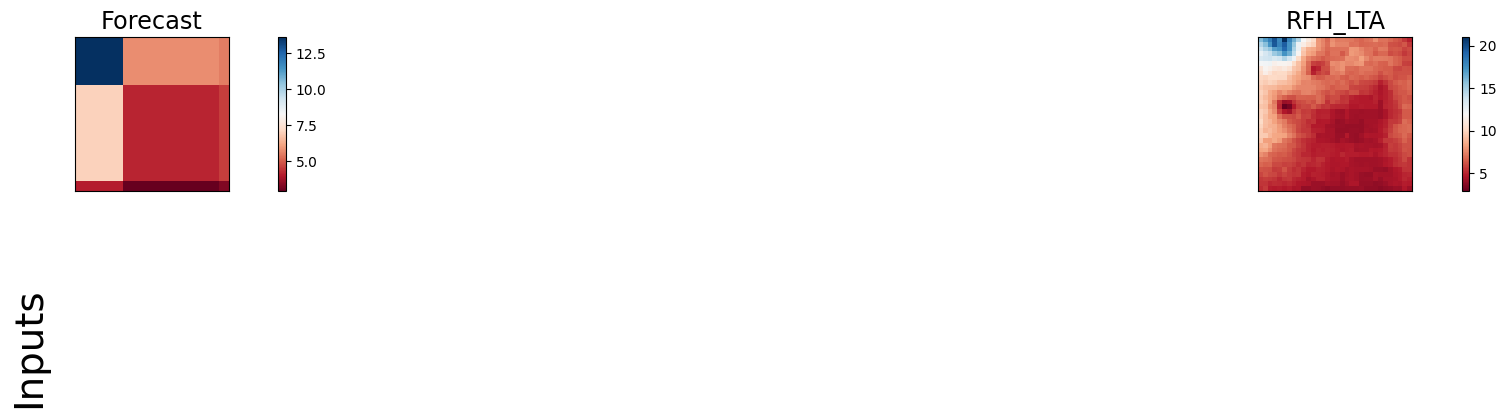

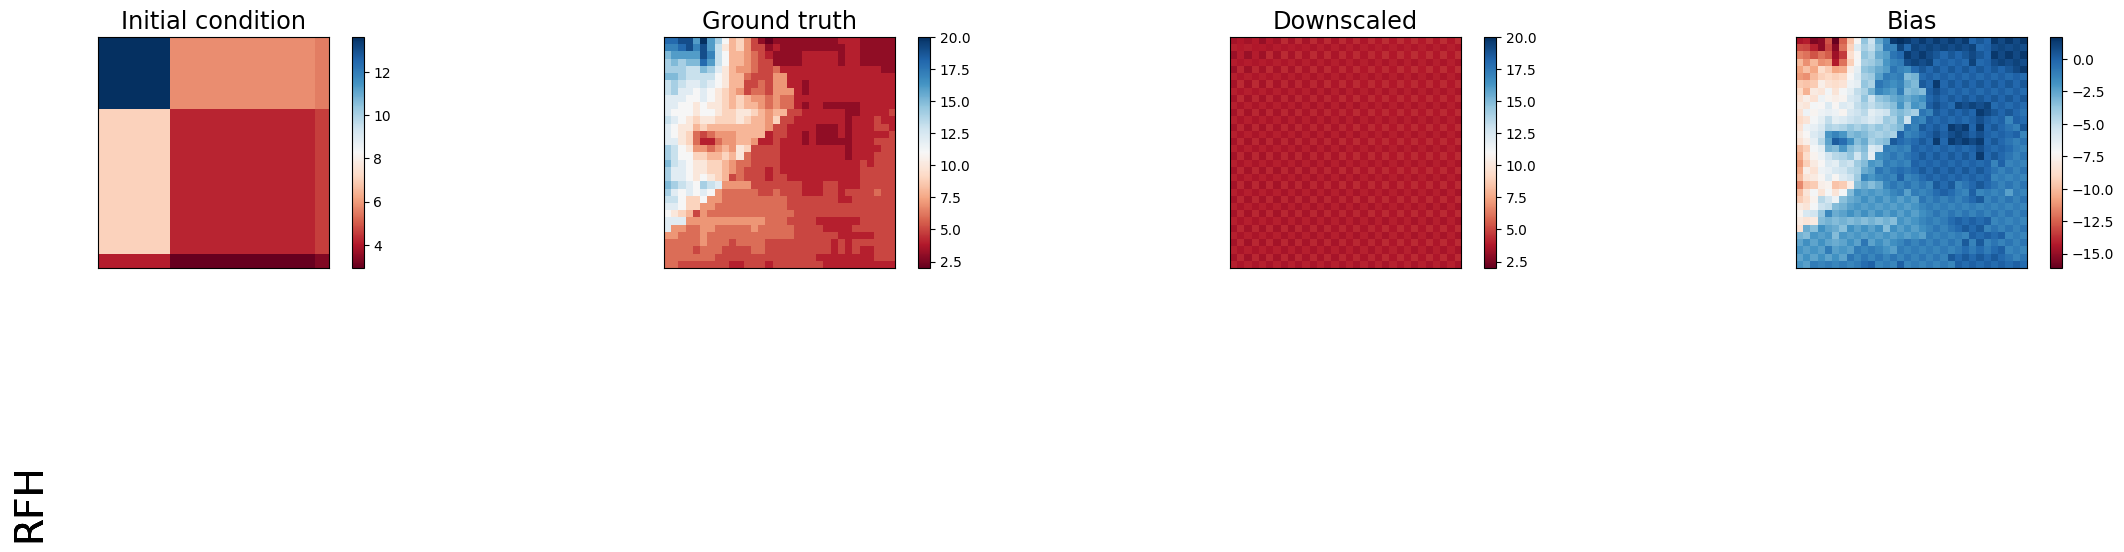

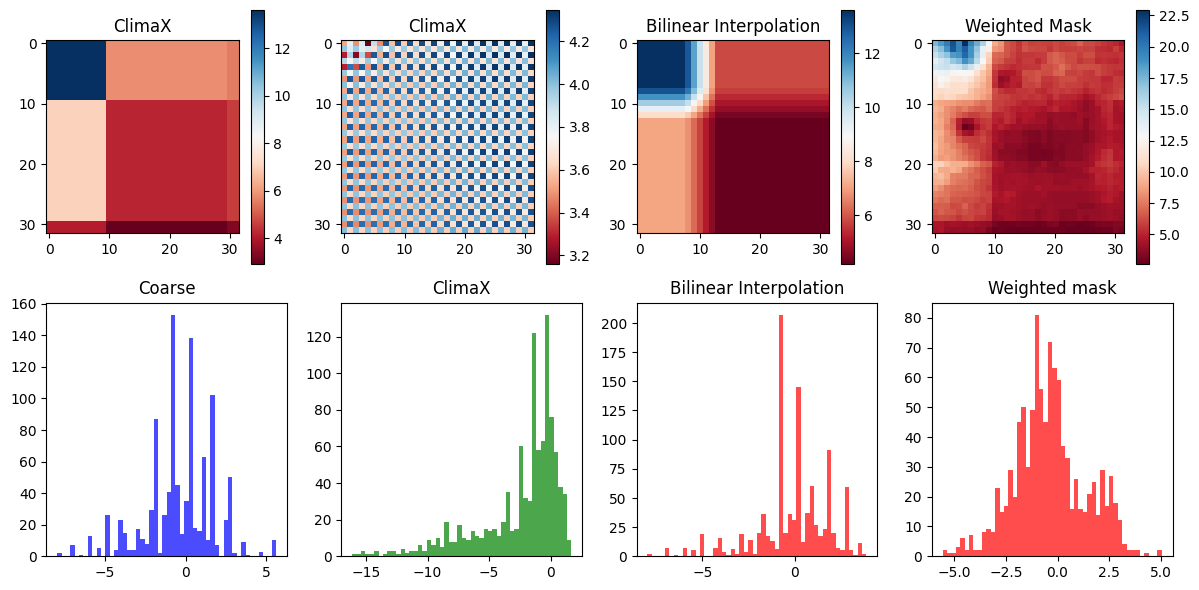

Time step 1
torch.Size([45, 1, 32, 32])


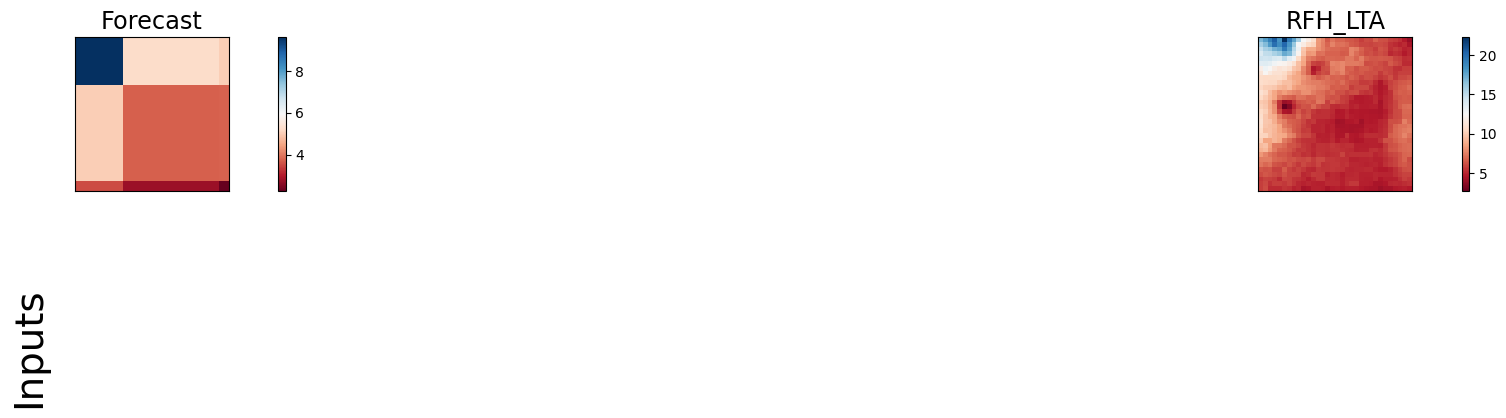

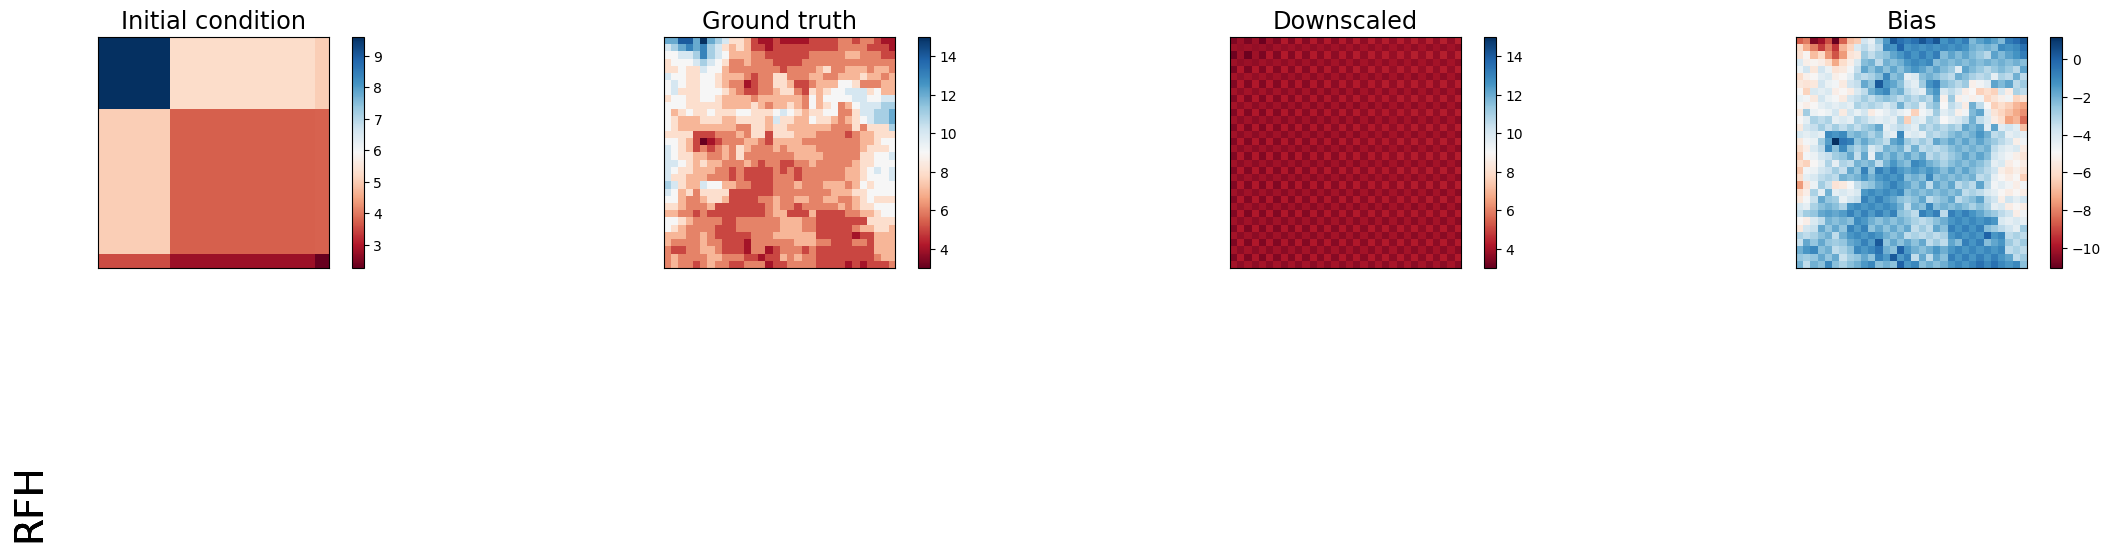

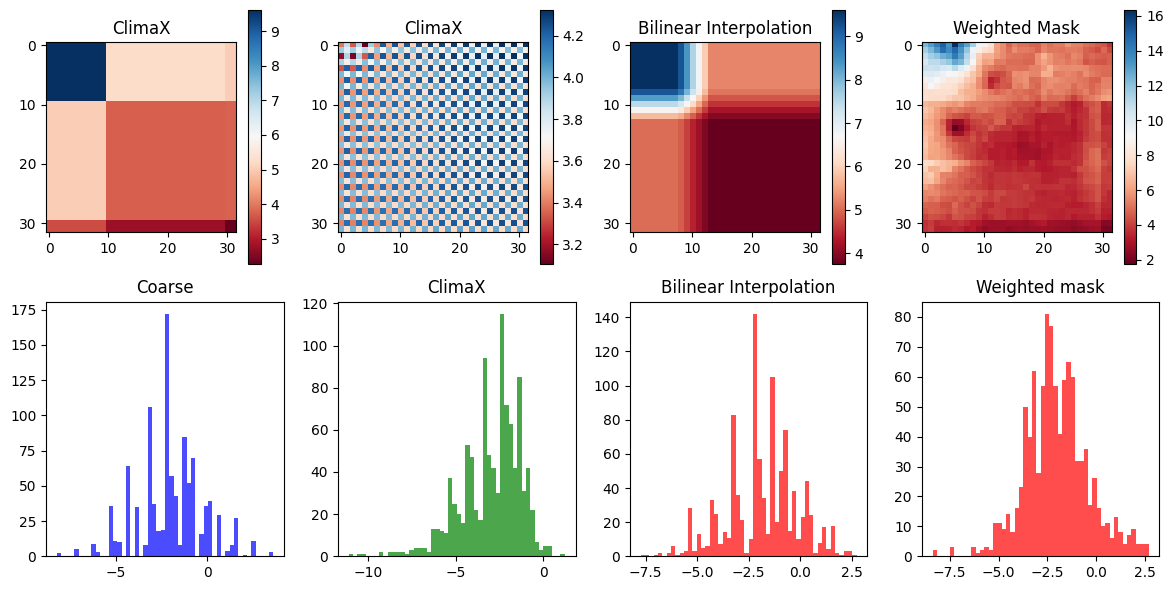

Time step 2
torch.Size([45, 1, 32, 32])


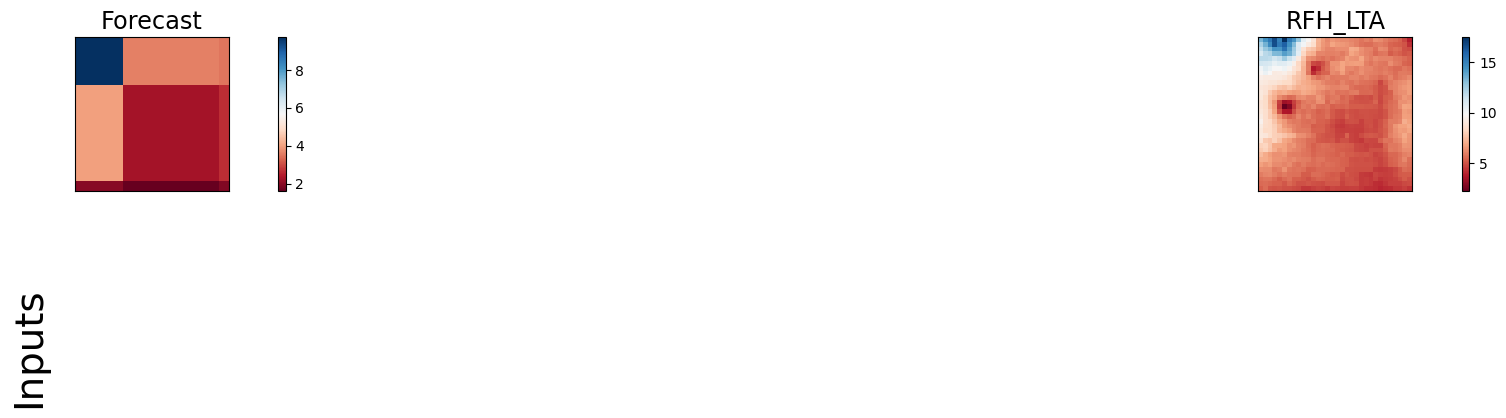

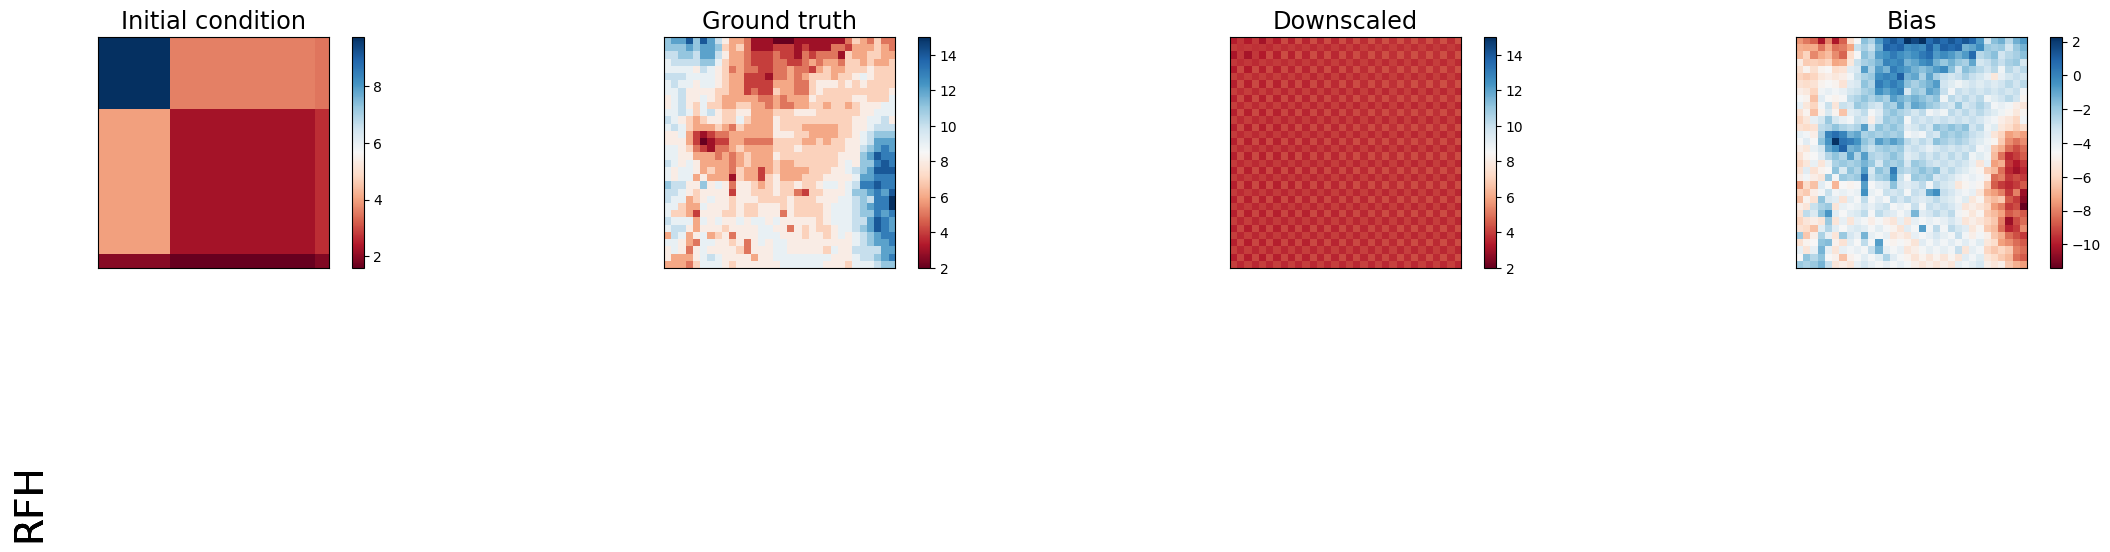

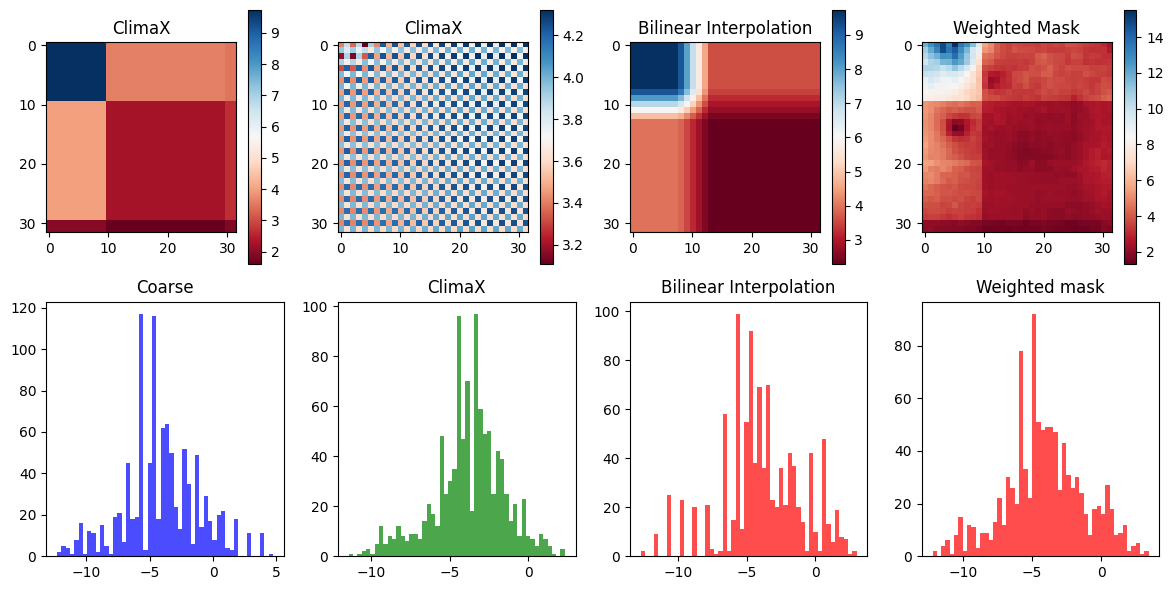

Time step 3
torch.Size([45, 1, 32, 32])


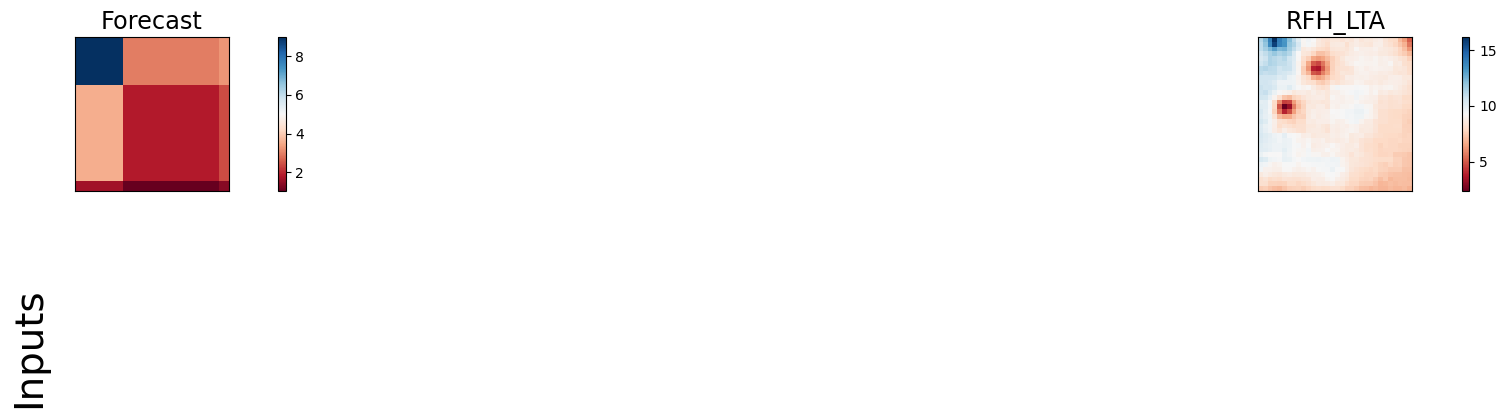

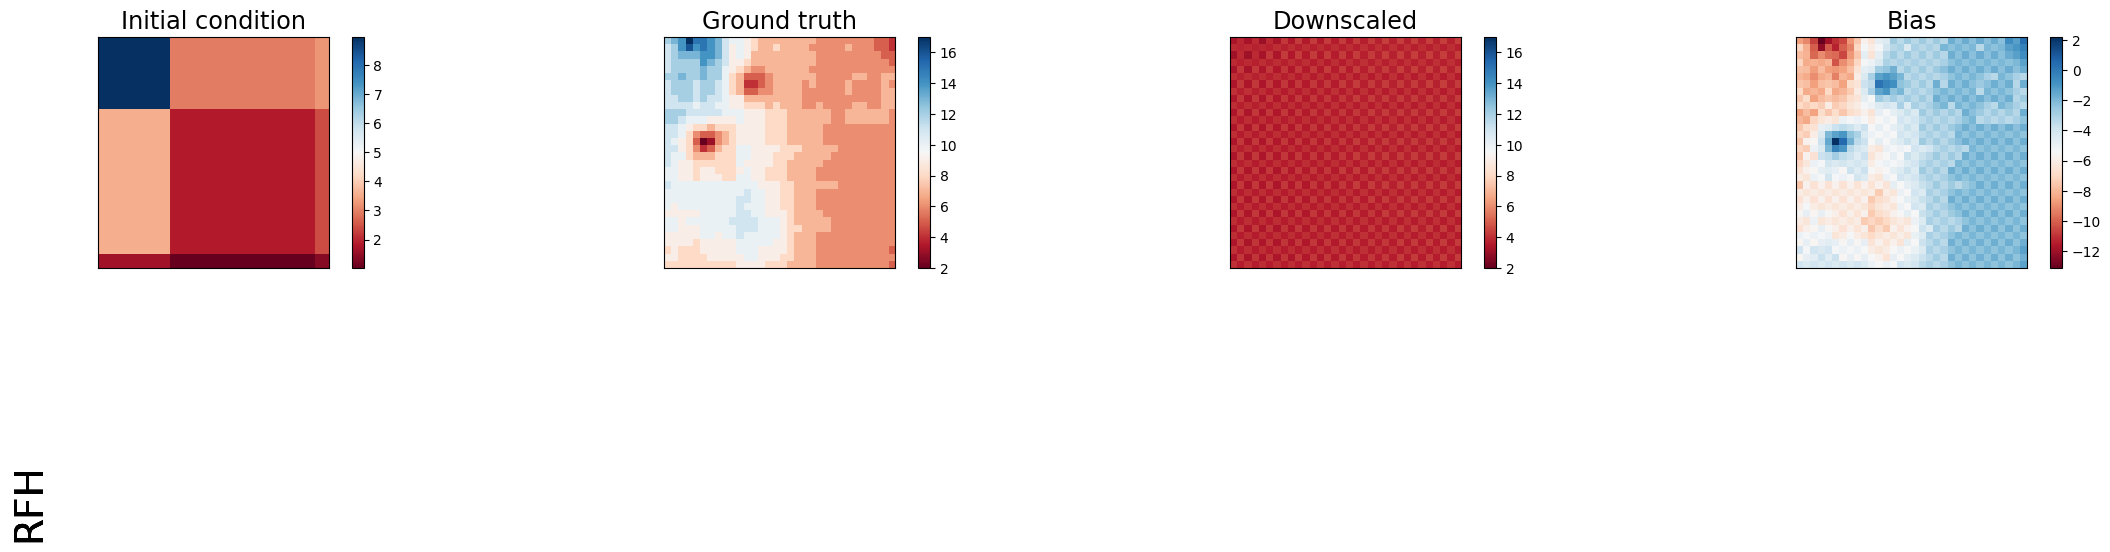

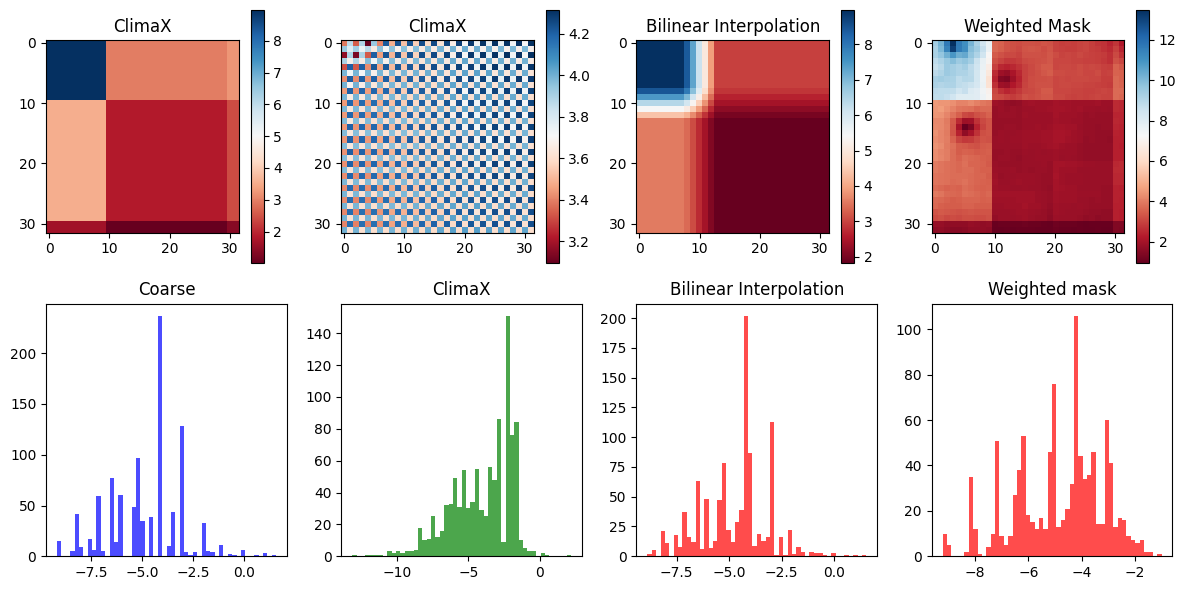

Time step 4
torch.Size([45, 1, 32, 32])


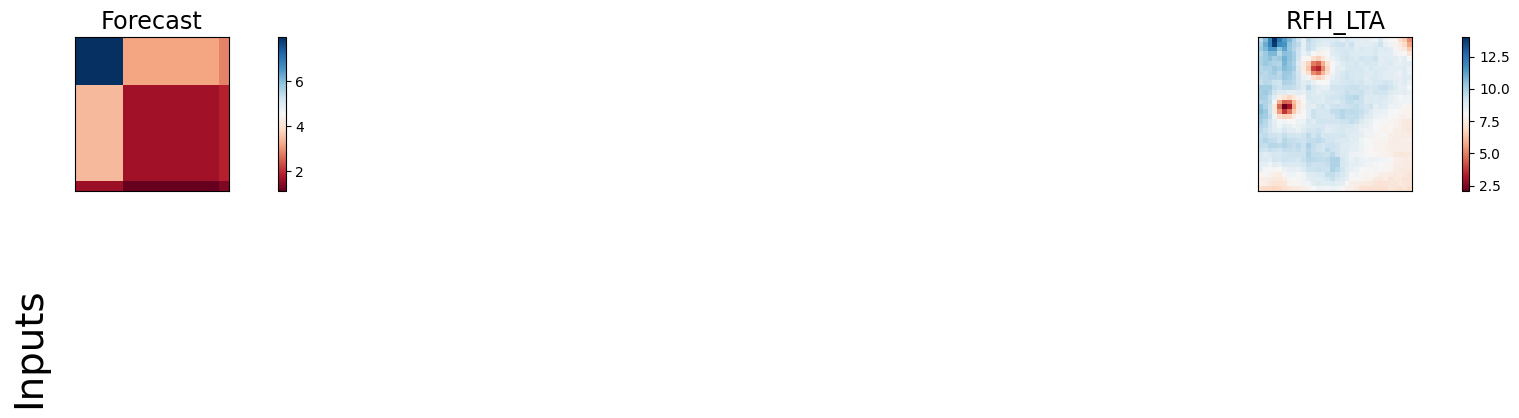

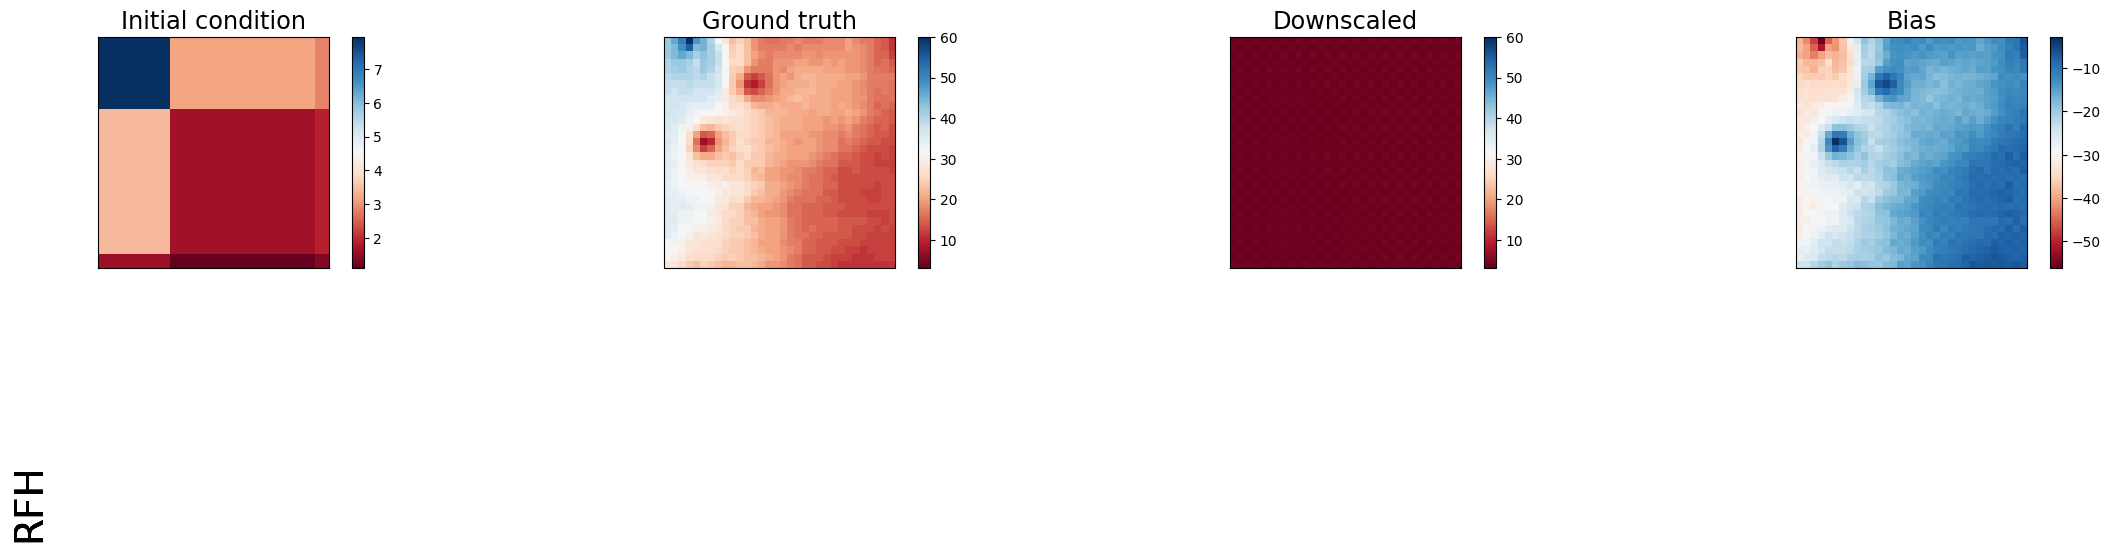

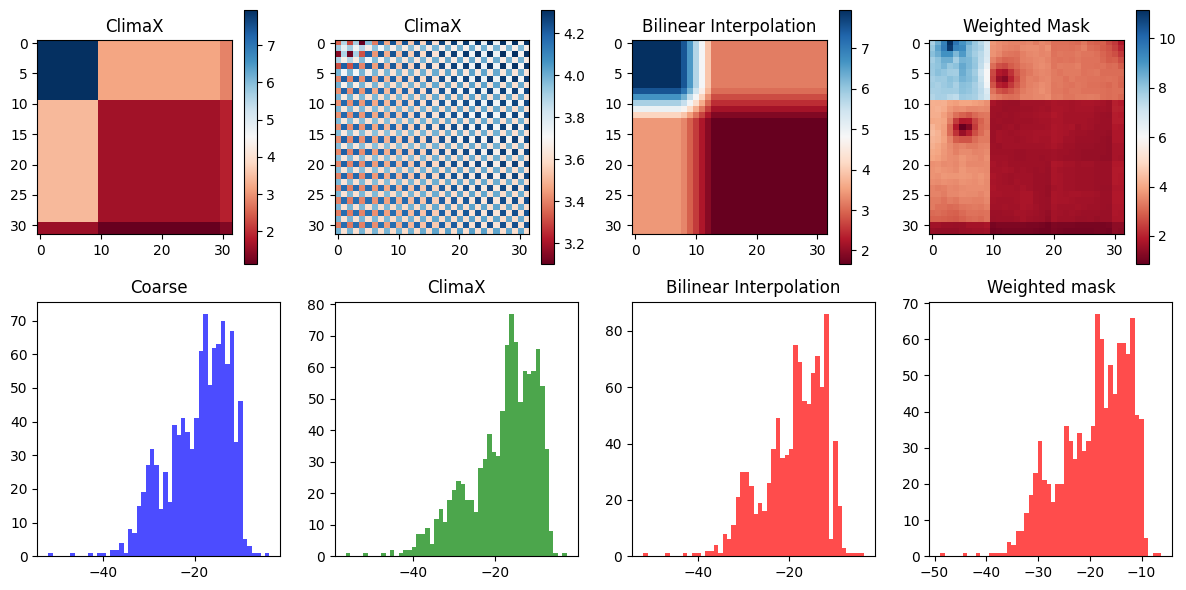

Time step 5
torch.Size([45, 1, 32, 32])


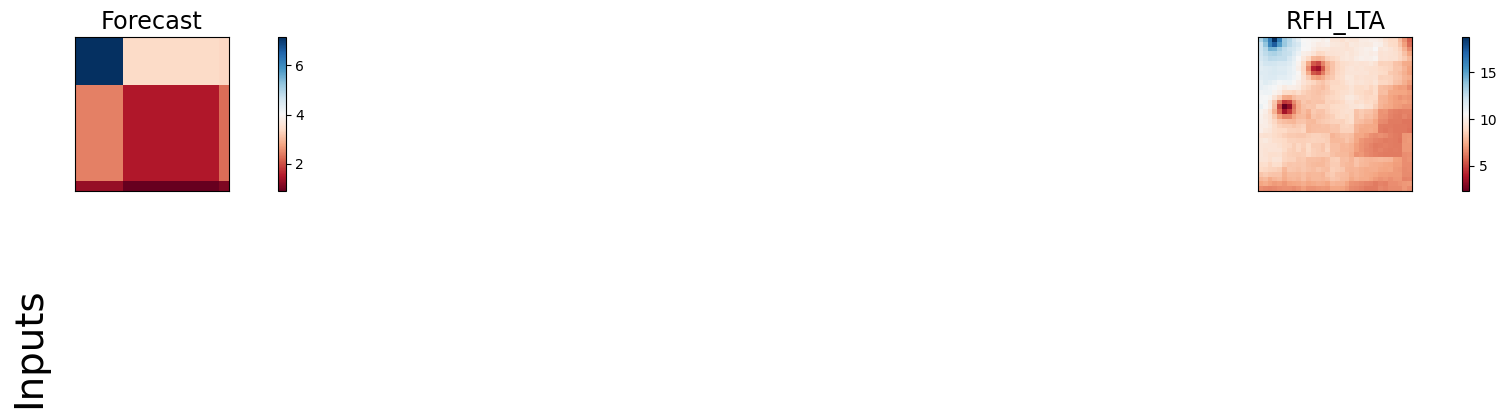

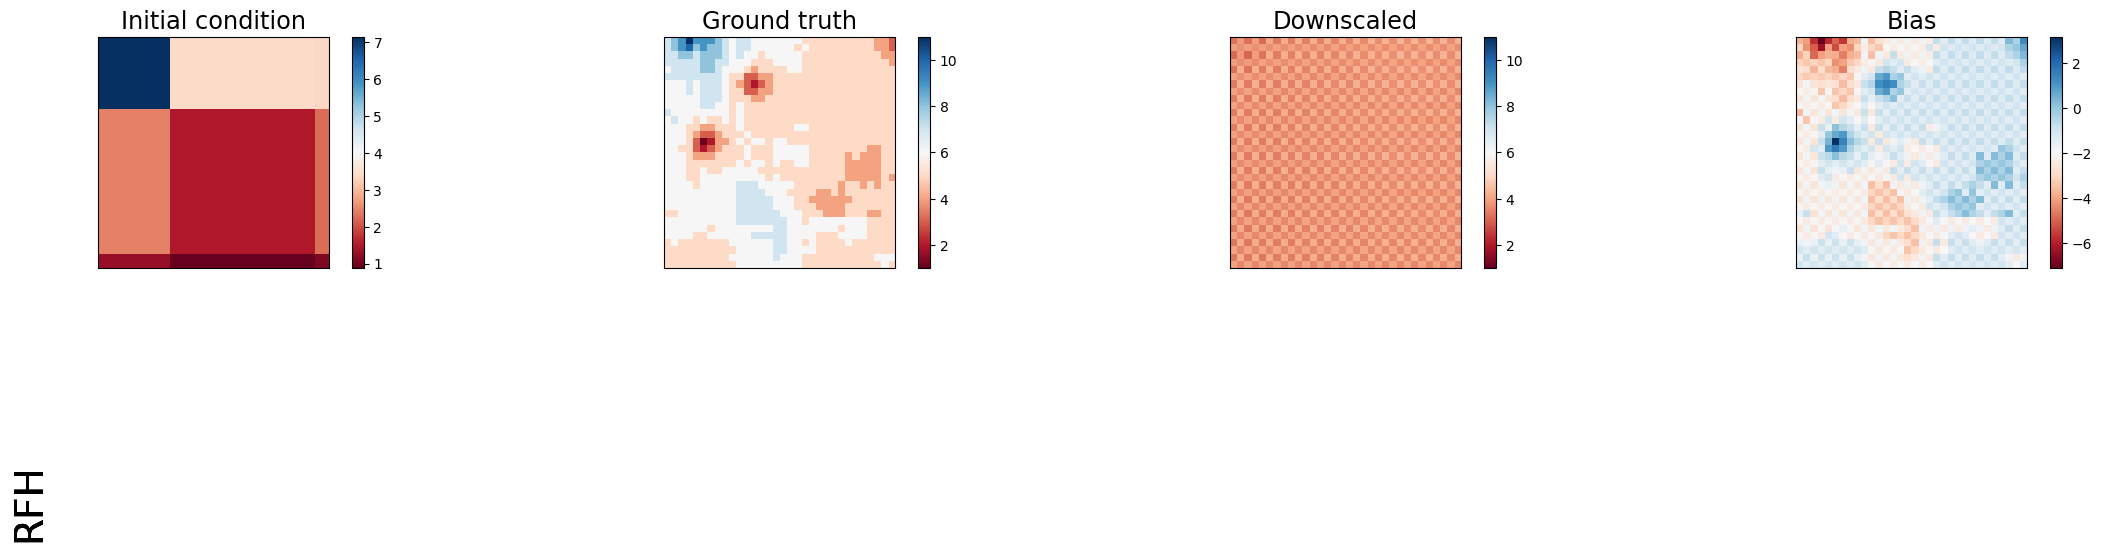

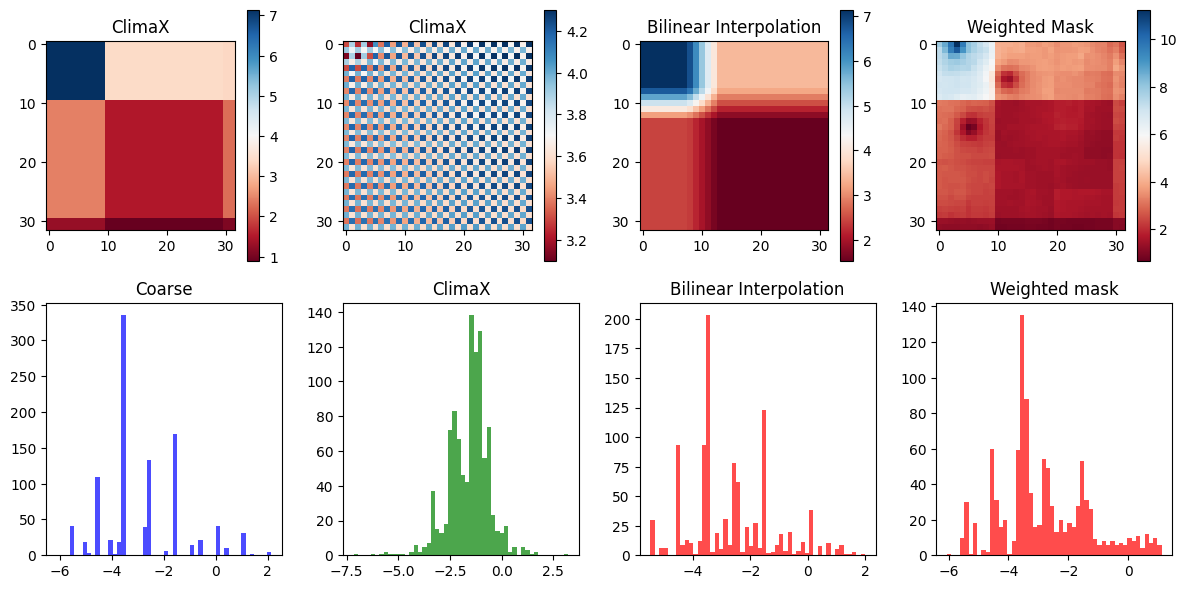

Time step 6
torch.Size([45, 1, 32, 32])


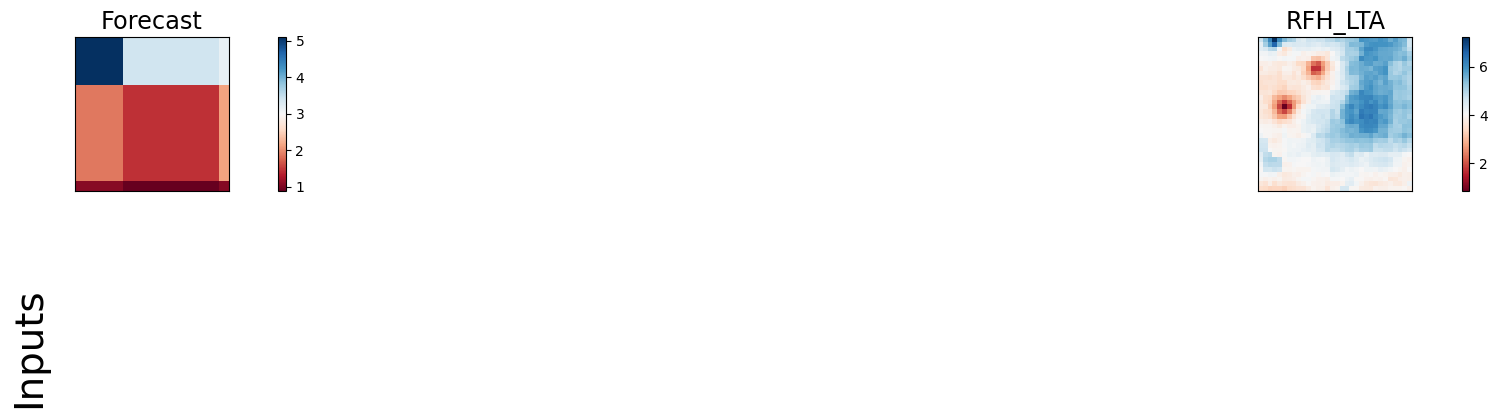

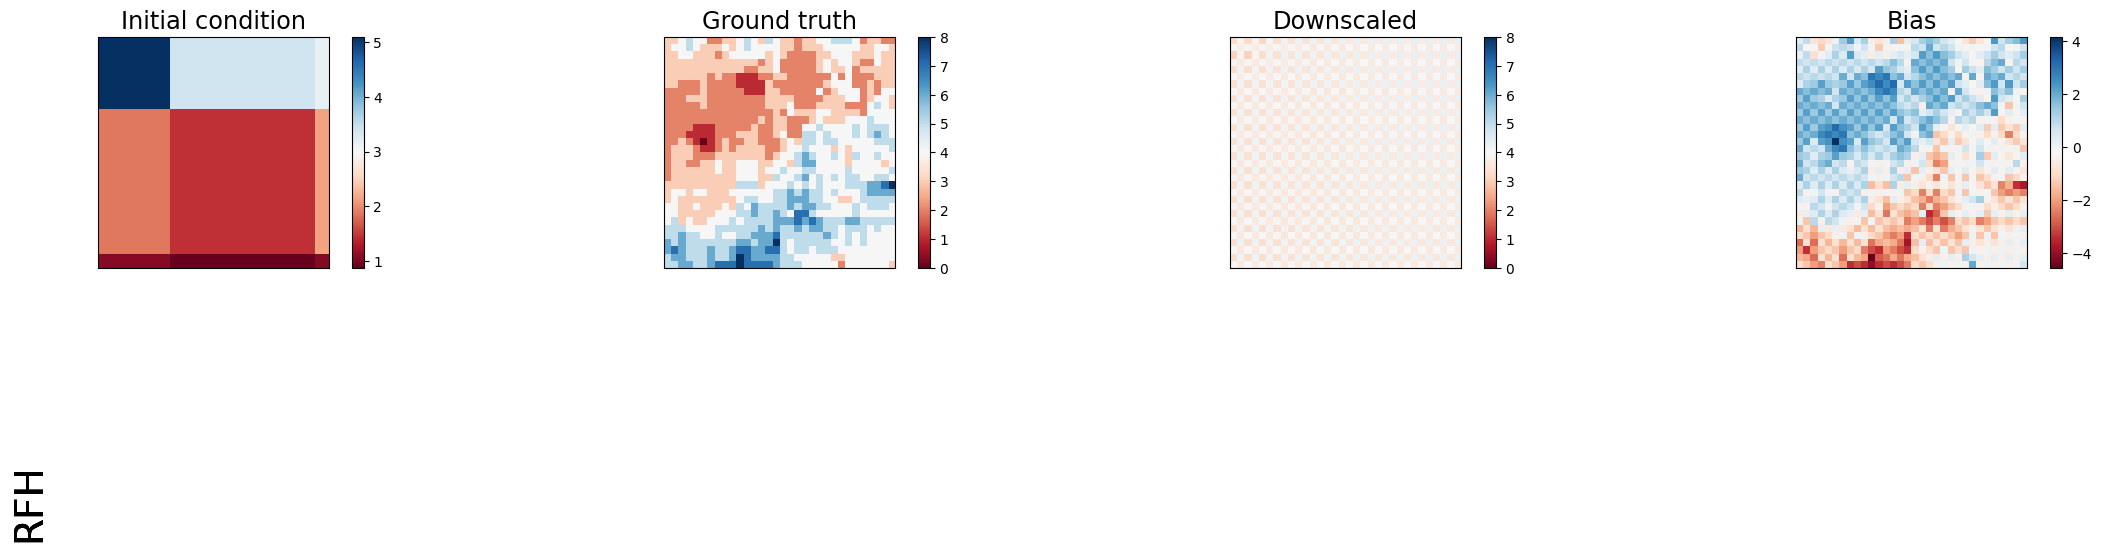

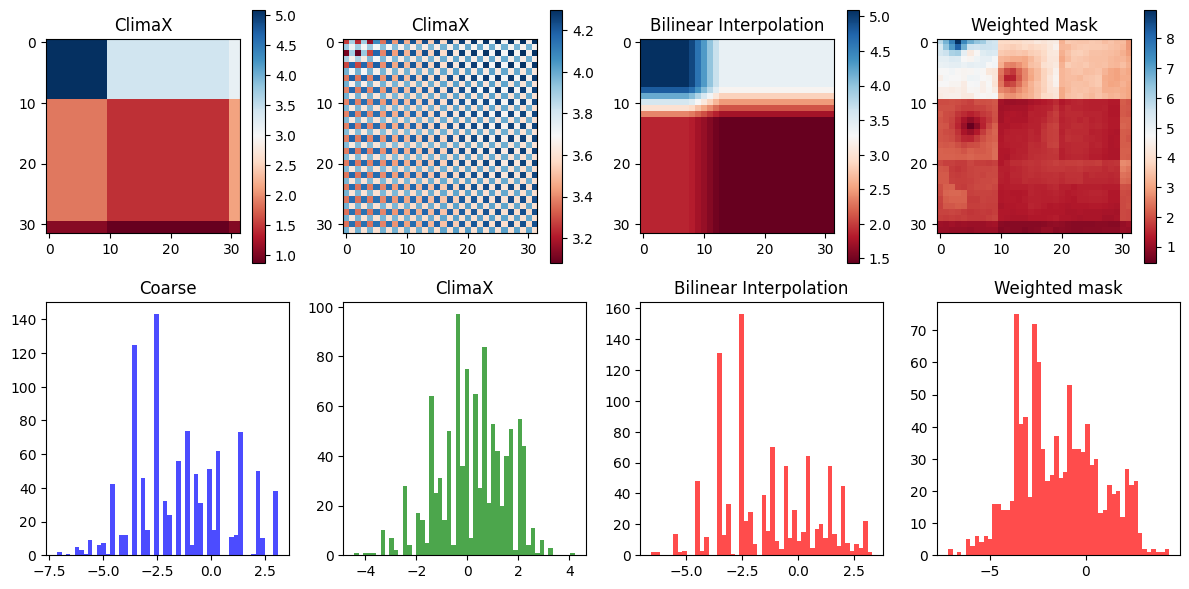

Time step 7
torch.Size([45, 1, 32, 32])


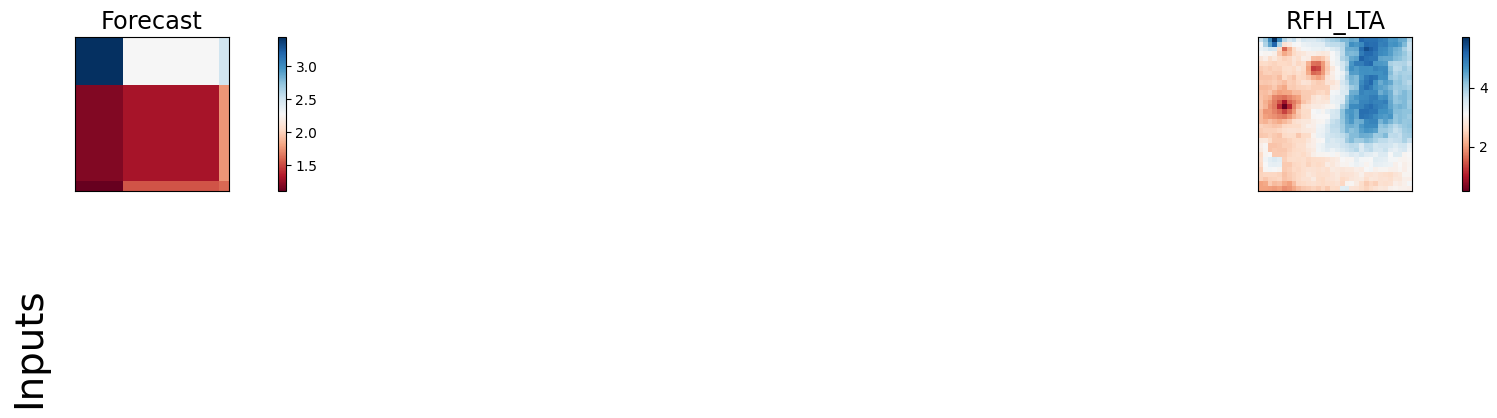

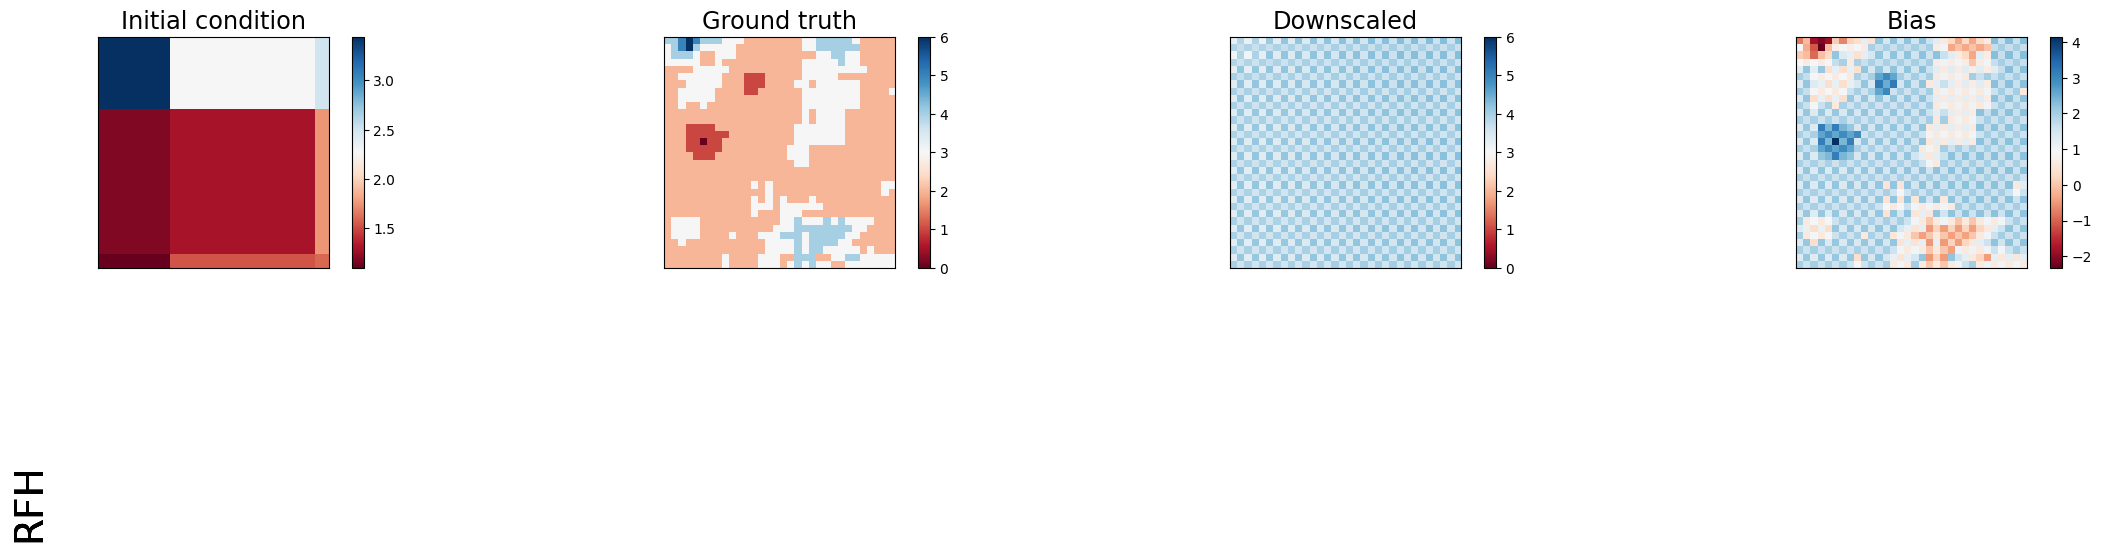

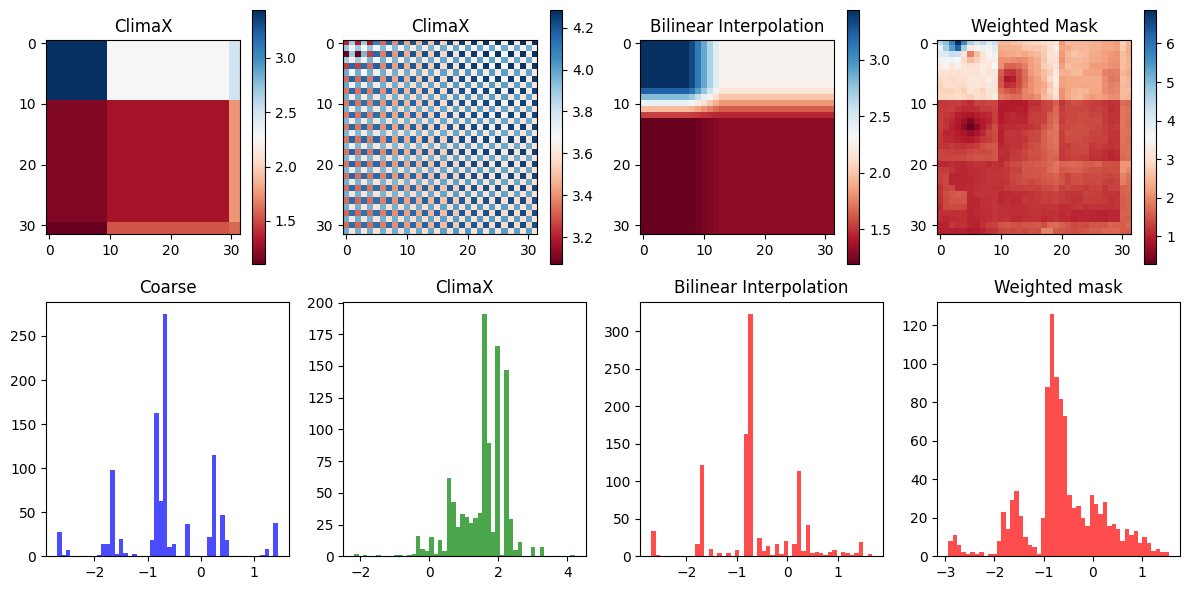

Time step 8
torch.Size([45, 1, 32, 32])


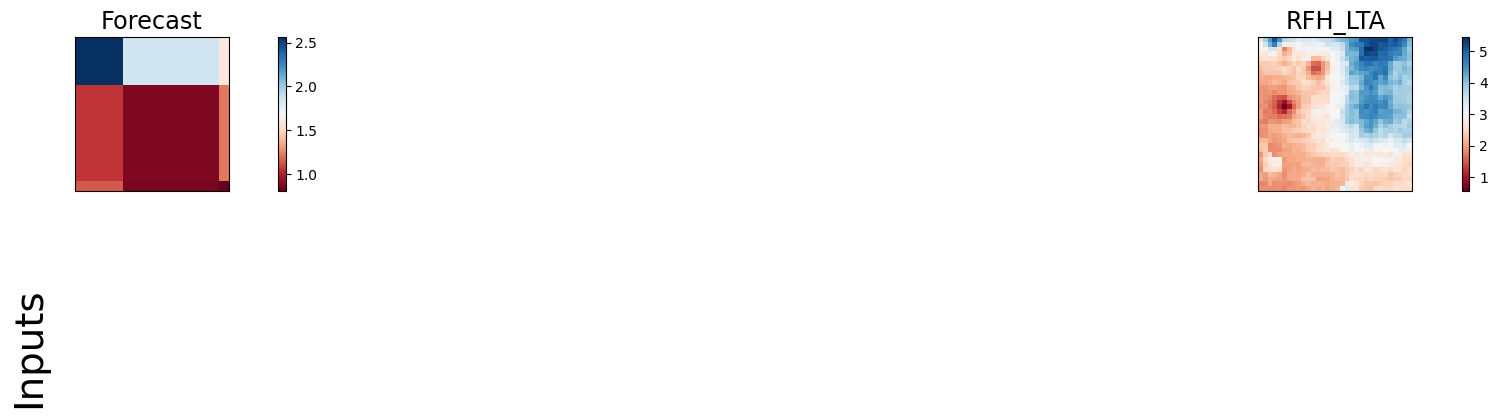

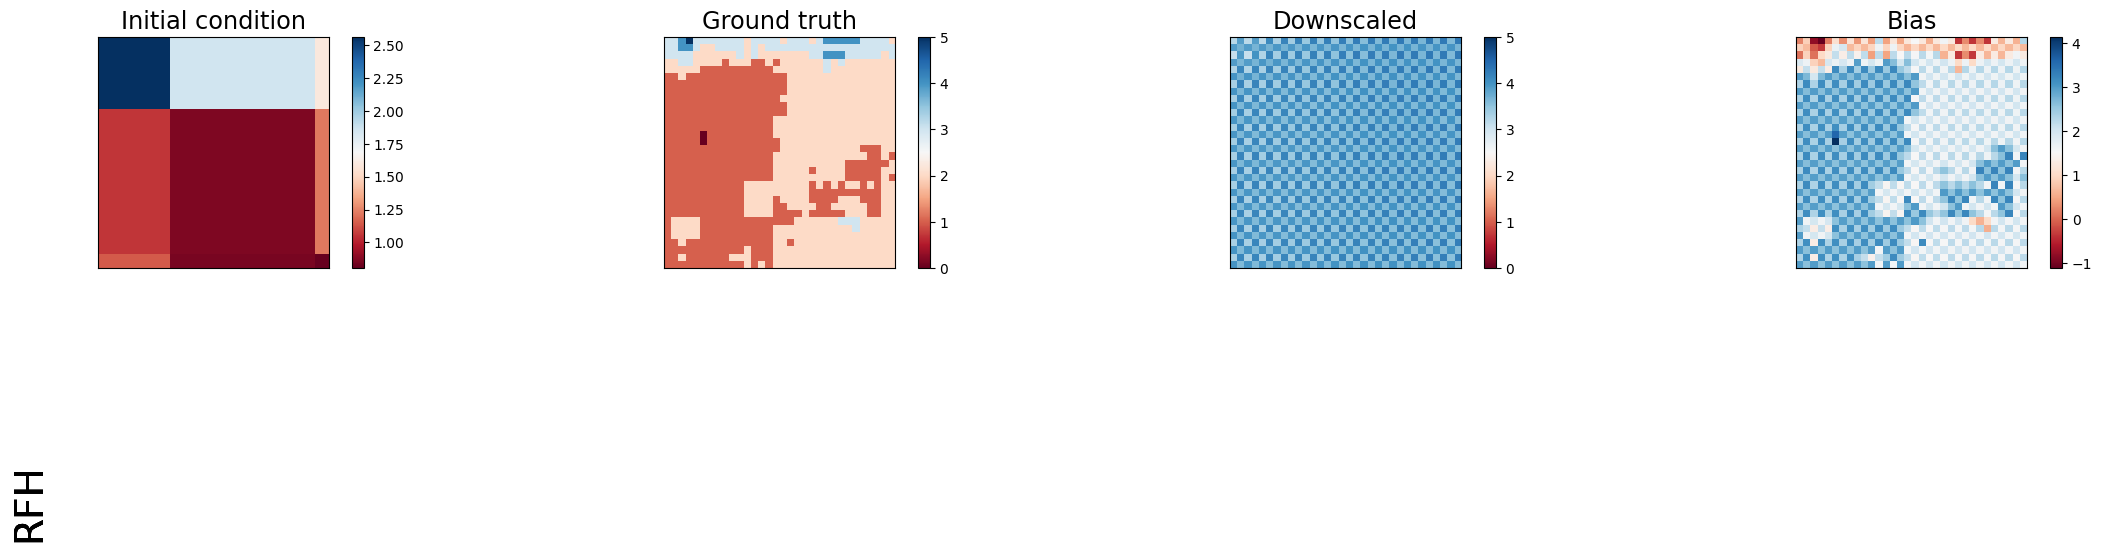

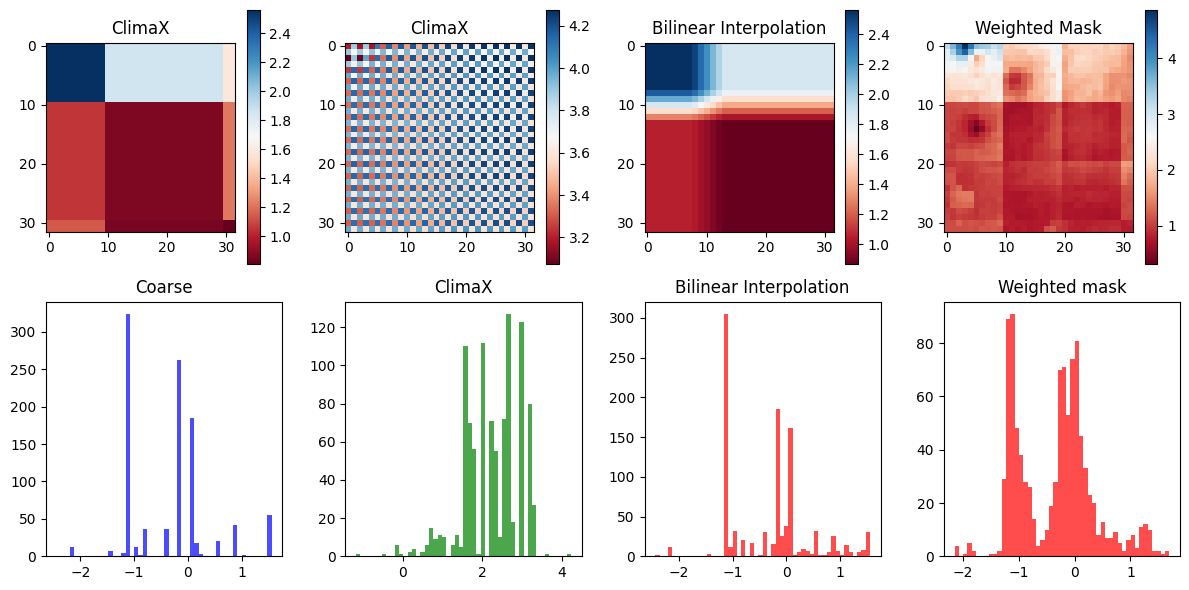

Time step 9
torch.Size([45, 1, 32, 32])


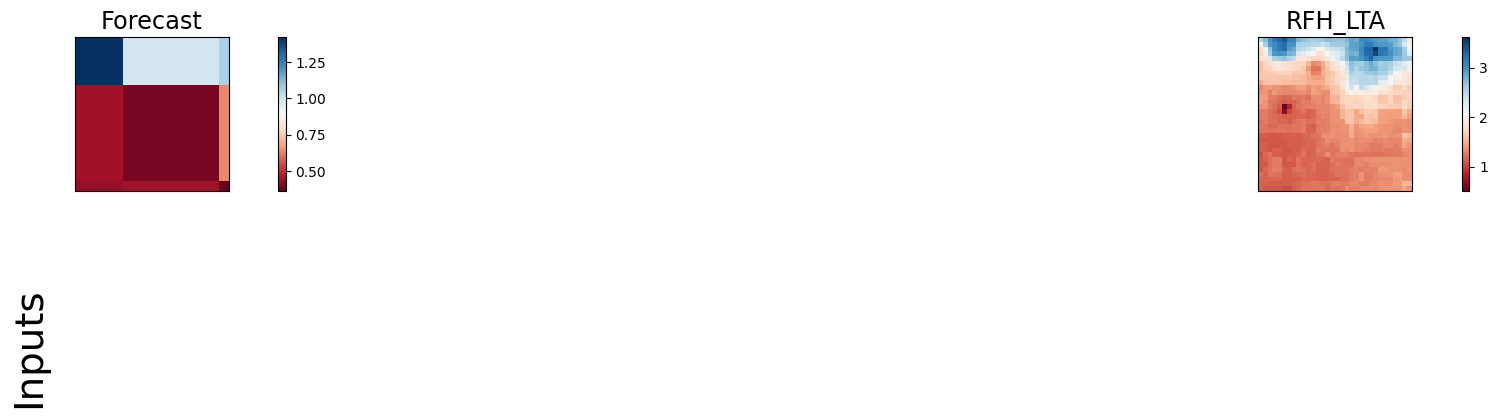

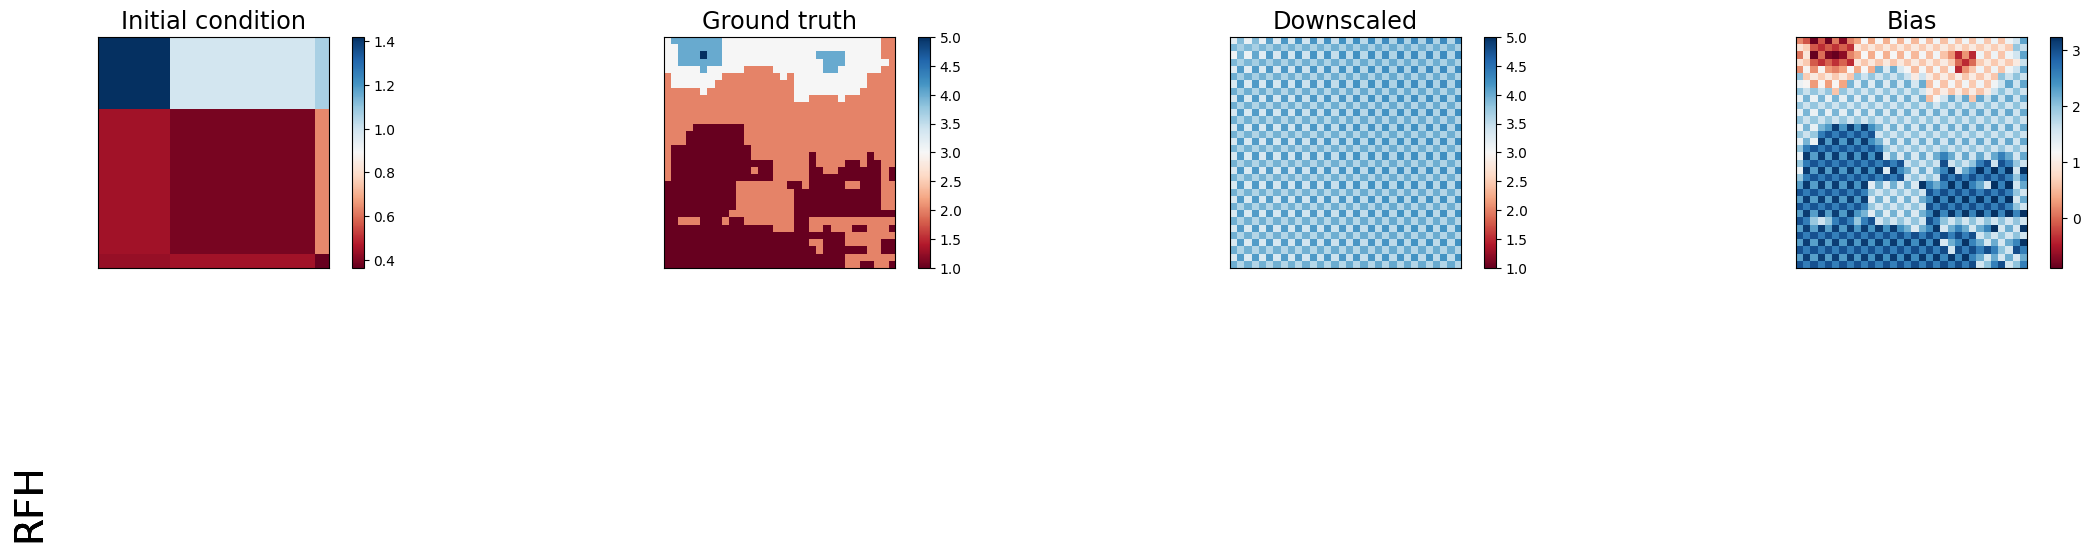

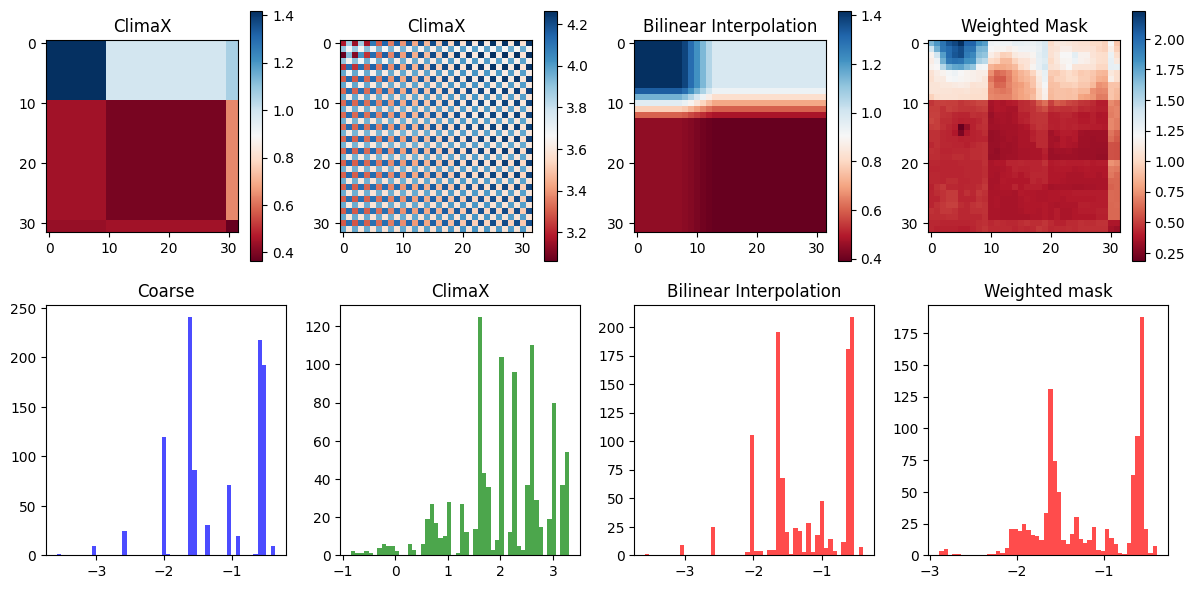

Time step 10
torch.Size([45, 1, 32, 32])


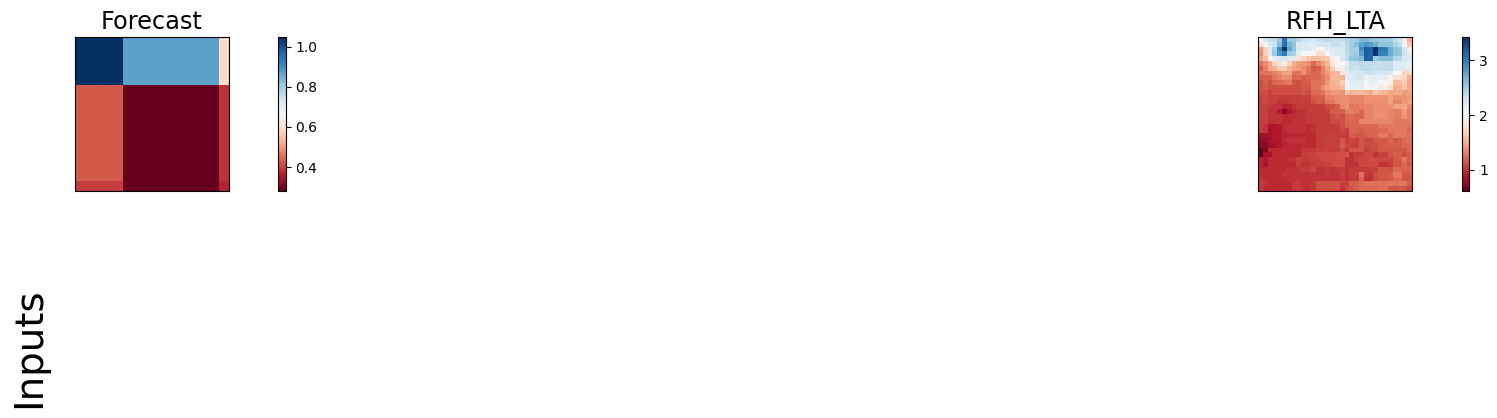

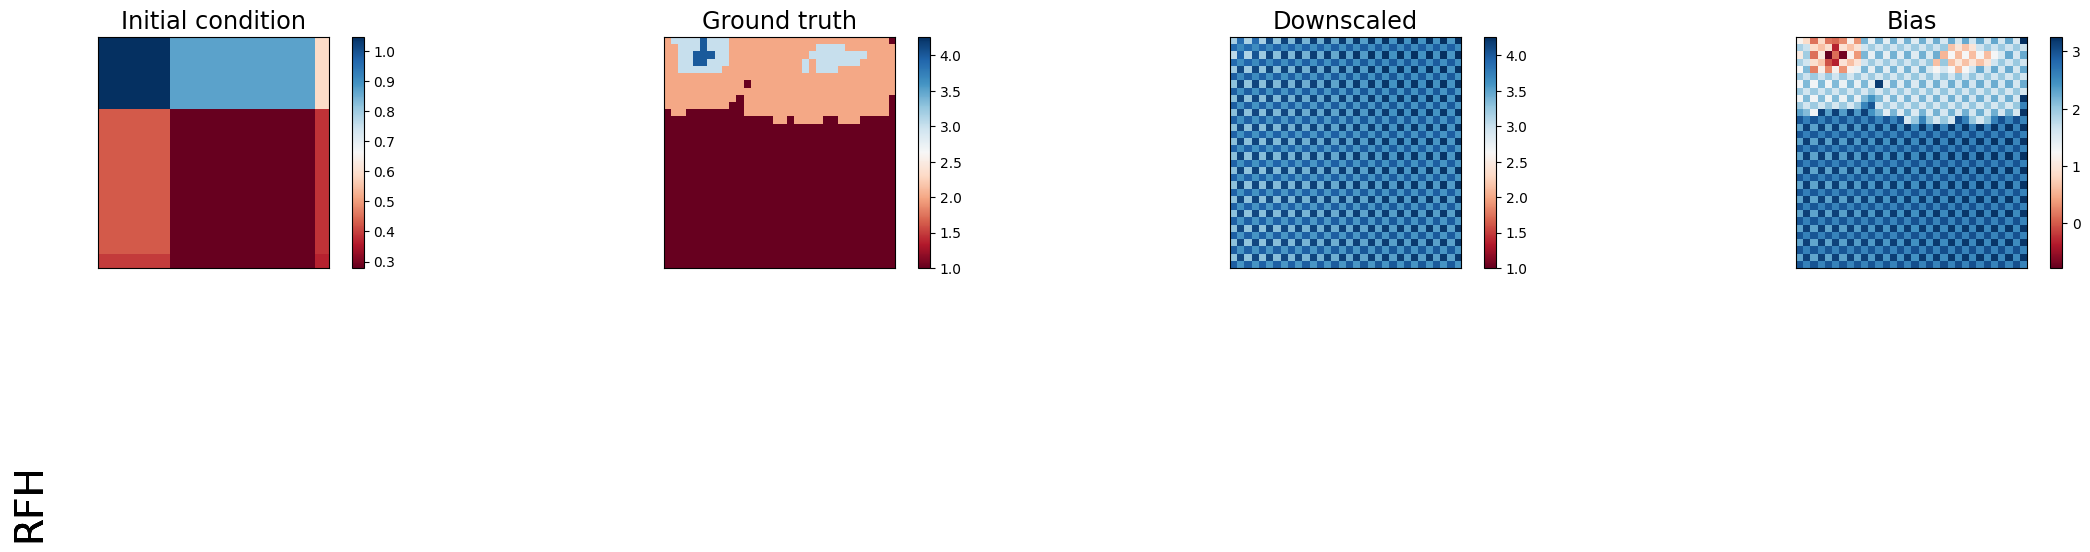

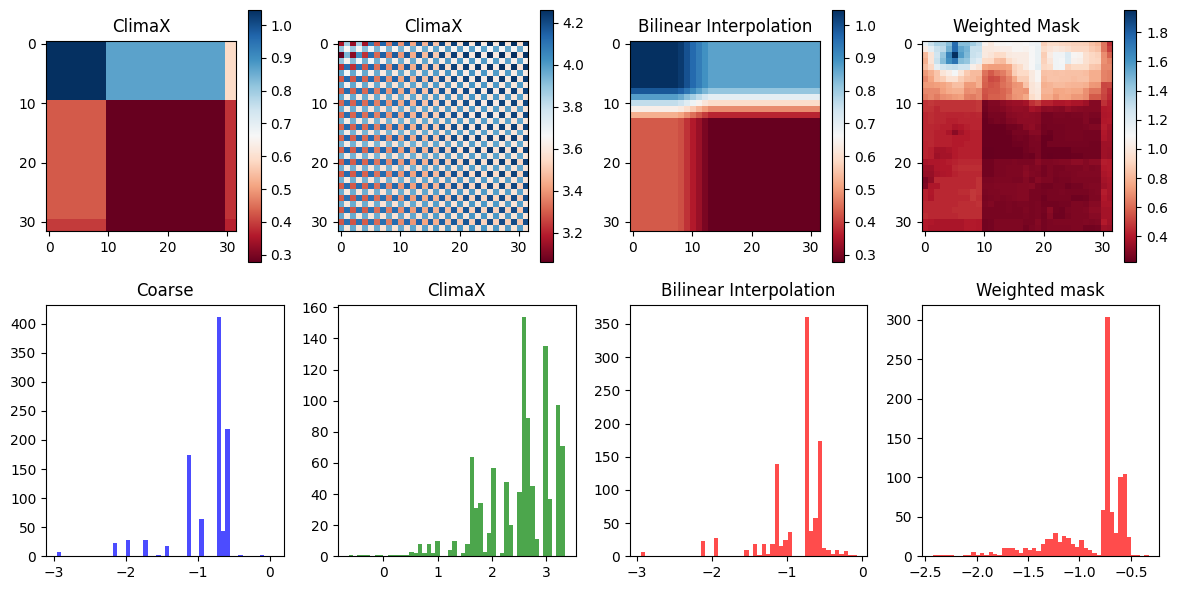

Time step 11
torch.Size([45, 1, 32, 32])


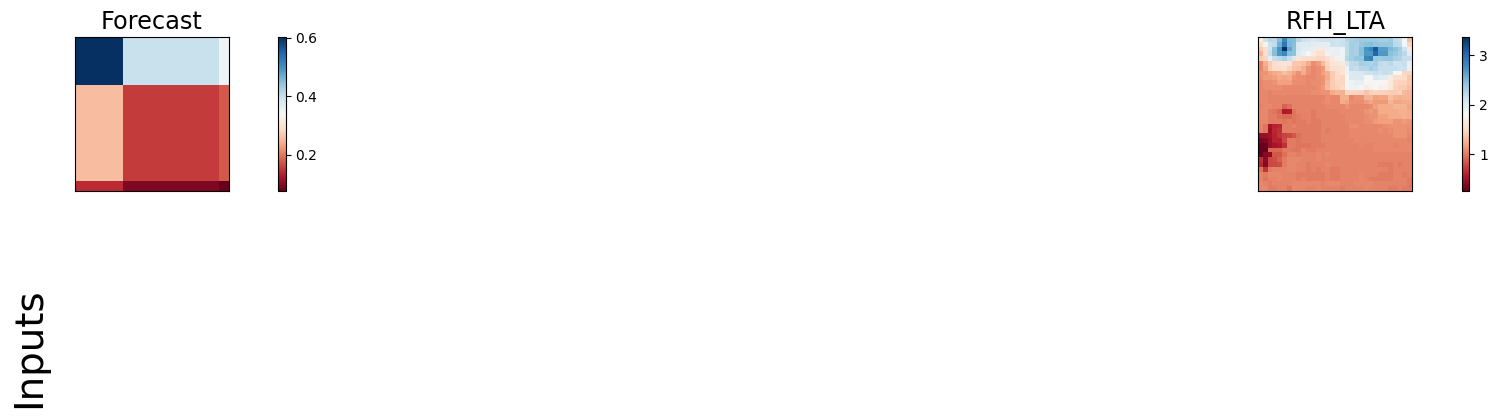

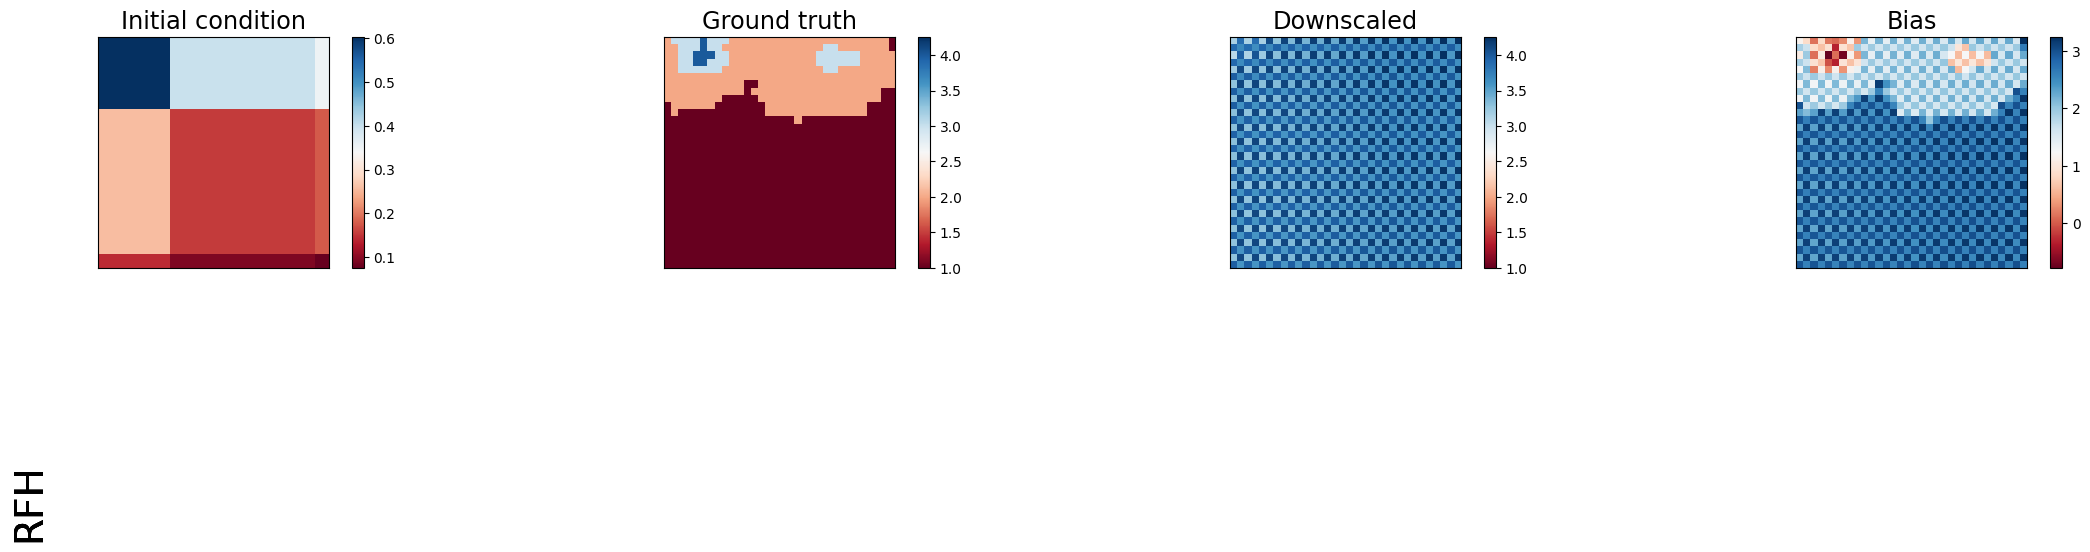

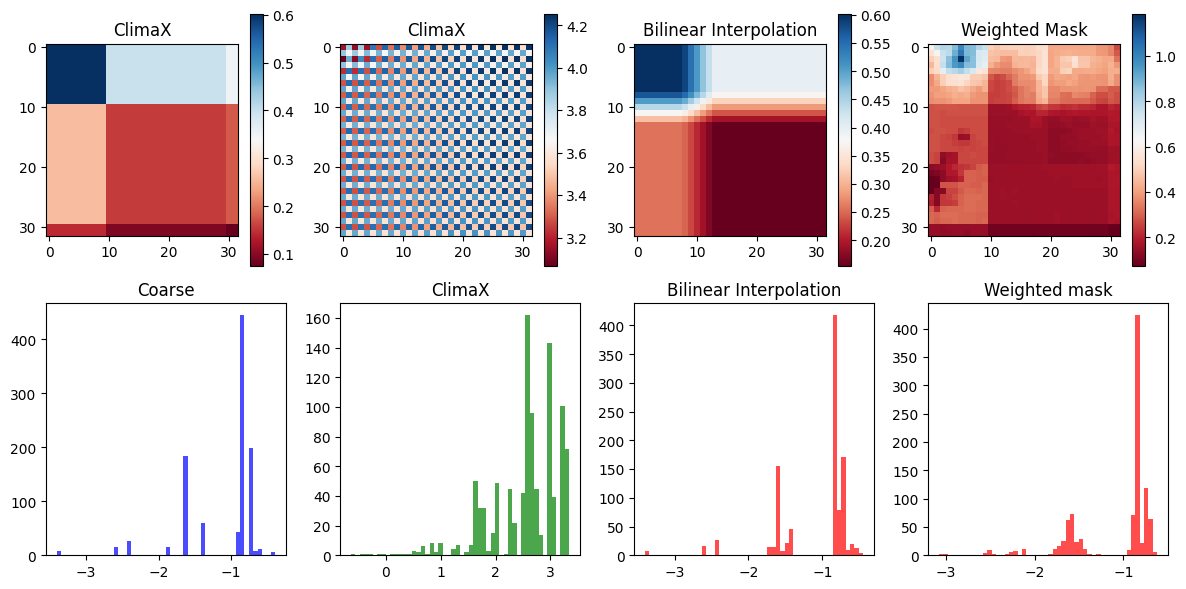

Time step 12
torch.Size([45, 1, 32, 32])


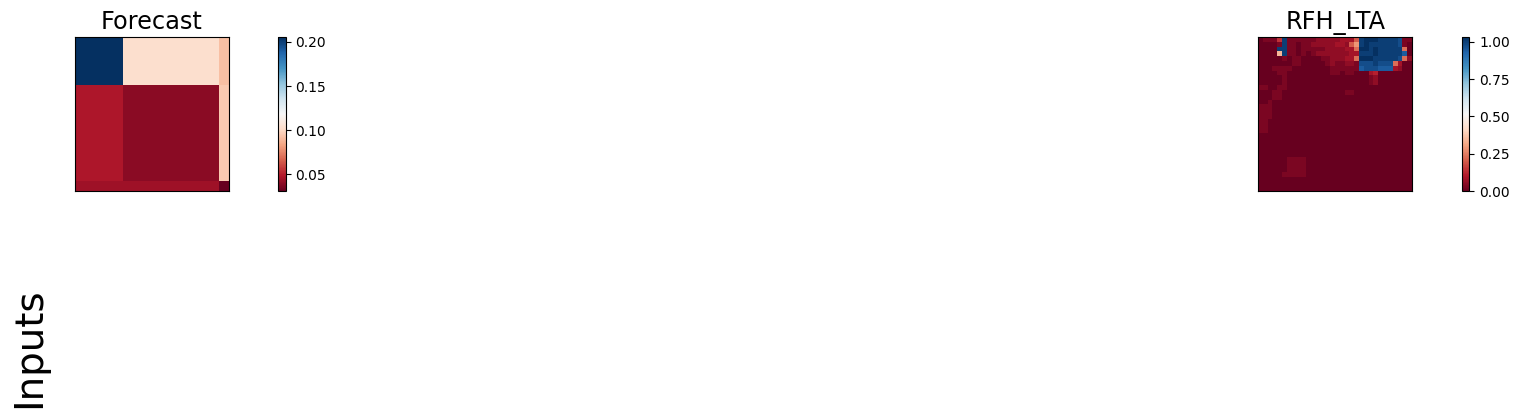

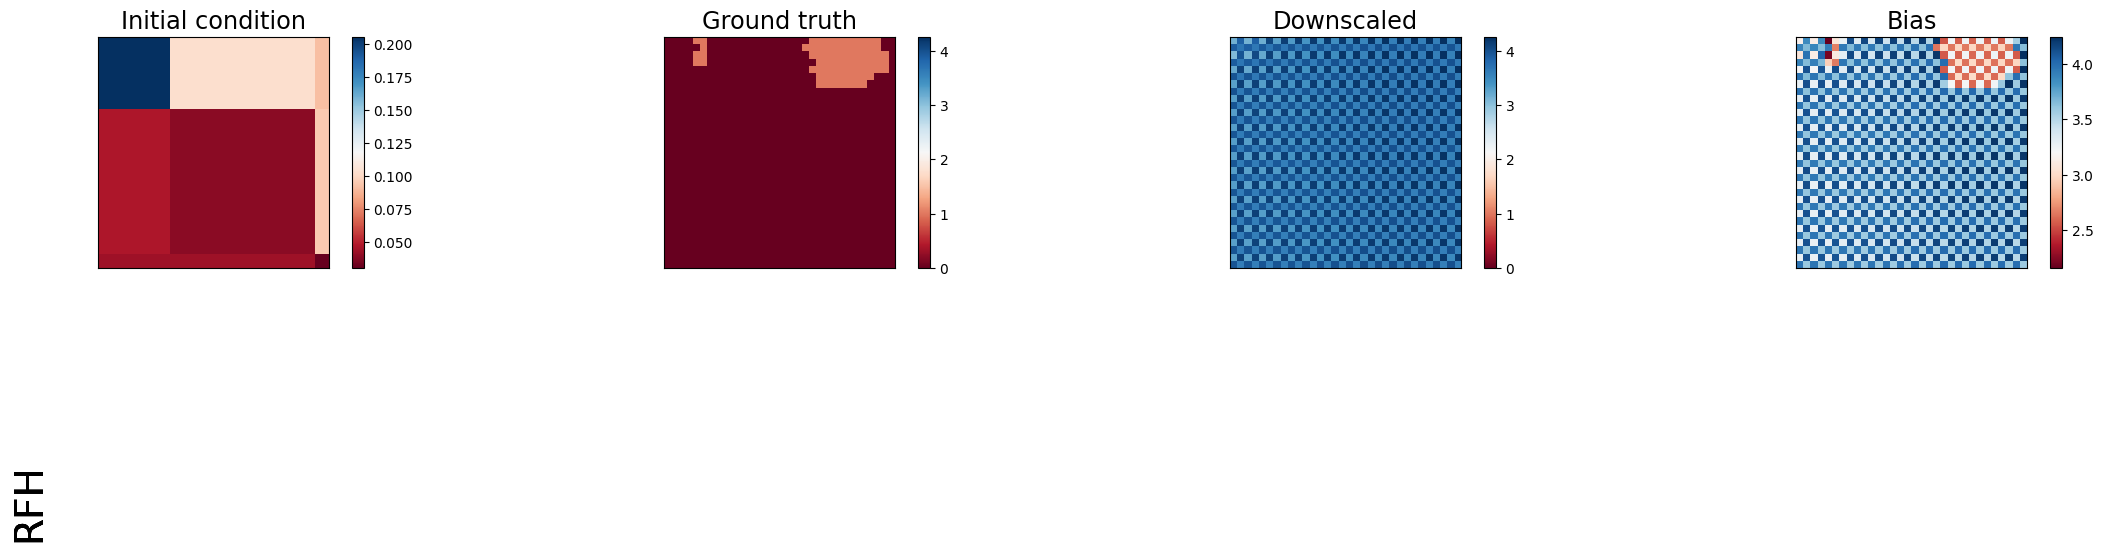

/tmp/ipykernel_7234/272363194.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_weights = square/np.mean(square)


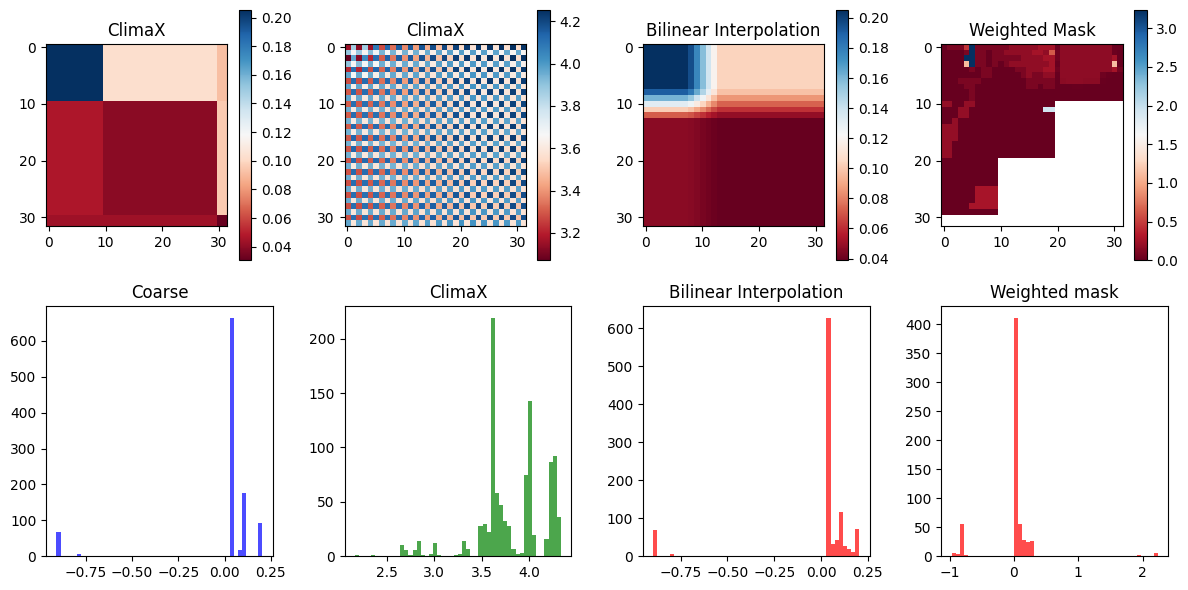

Time step 13
torch.Size([45, 1, 32, 32])


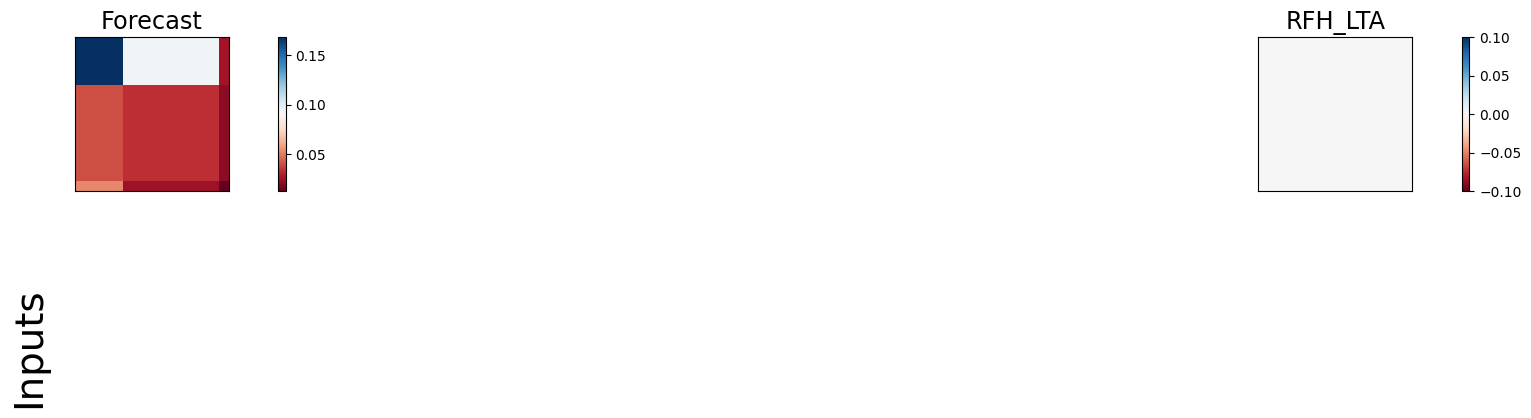

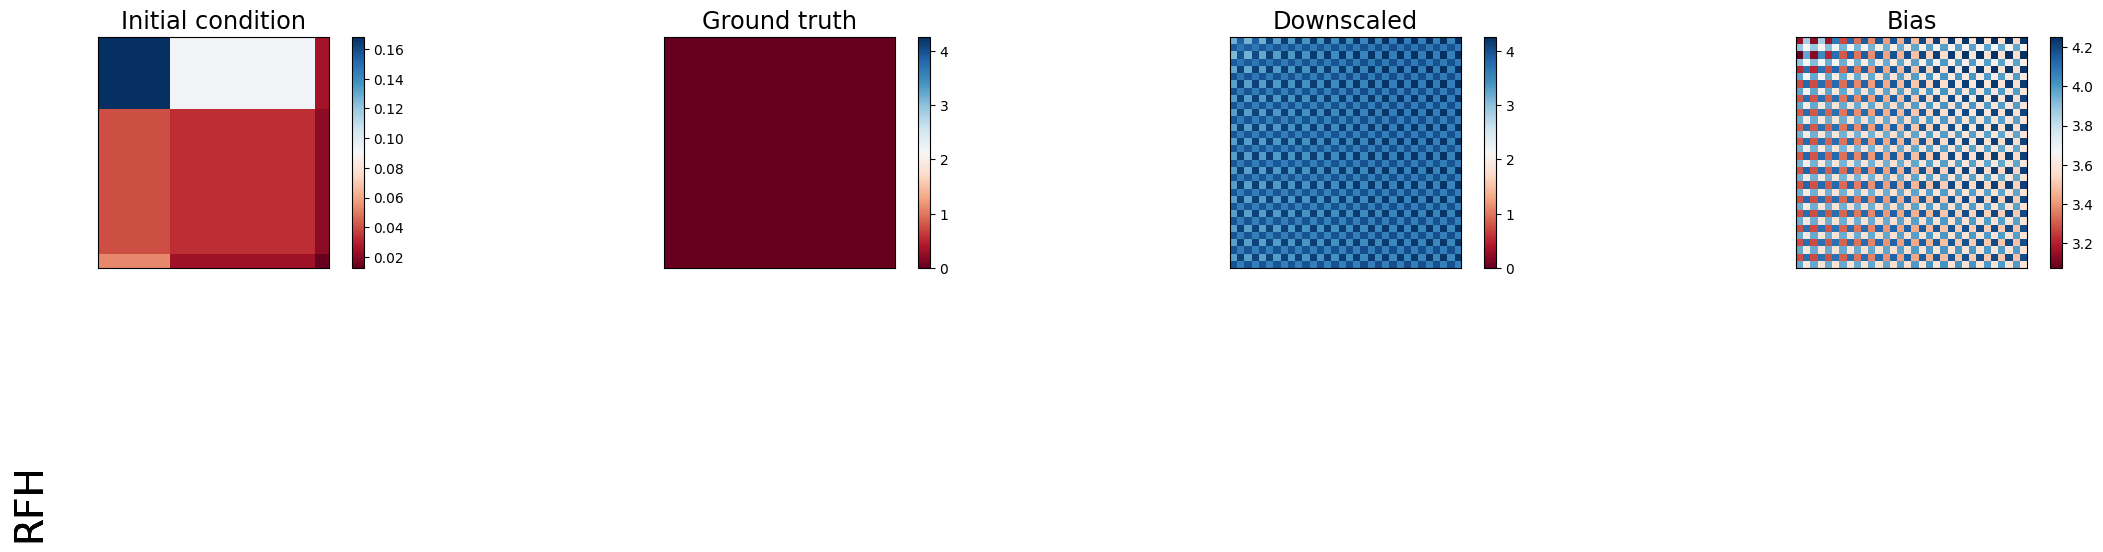

AttributeError: 'float' object has no attribute 'item'

In [20]:
task = "10 days"
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        'forecast', 'rfh', 'rfh_lta']
    ,"img_size" :  [32, 32],
      "patch_size" :   2,
      "embed_dim":   1024,
      "depth" : 8,
      "decoder_depth" :  2,
      "num_heads": 8,
    "mlp_ratio": 2,
    "drop_path": 0.5,
    "drop_rate": 0.5,
    
}
net = ClimaX(**net_args)
model = ClimateDownscalingModule(net=net, pretrained_path='ClimaX/exps/downscale/checkpoints/epoch_012.ckpt')

datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Jordan/data_npz',
    variables=['forecast', 'rfh_lta'],
    out_variables=['rfh'],
    buffer_size= 2000,
    batch_size= 64
)

normalization = datamodule.transforms
print(normalization)
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())

denormalize_out = transforms.Normalize(datamodule.output_transforms.mean /datamodule.output_transforms.std , 1/datamodule.output_transforms.std)

datamodule.setup()


gt,pred,tensors,var_name, pred_task,tensors_pred = visualize_downscale(model, datamodule,mean_norm, std_norm, pred_range, var_name = "RFH", var_id = 1,desired_batch_index=1)
forecast, rfh_lta = tensors[0], tensors[1]
timesteps=gt.shape[0]



for t in range(timesteps):
    print("Time step",t)
    print(gt.shape)
    plot_inputs(tensors, var_name, pred_task,t)
    plot_pred(tensors_pred, var_name, pred_task,t)
    

    bilinear_inter = bilinear_interpolate(forecast[t].unsqueeze(dim=0))
    weighted_mask = Downscale_Weight(rfh_lta[t].cpu().numpy(),forecast[t].cpu().numpy(), verbose=False)
    
    compare_results(gt, forecast, pred , bilinear_inter, weighted_mask, model,t,denormalize_out)
    plot_compare(gt, forecast, pred, bilinear_inter, weighted_mask,t,denormalize_out)
    
    
    
    
    



    



In [ ]:
! python src/climax/climate_downscaling/train.py --config configs/downscaling_climax_ecmwf.yaml     --trainer.max_epochs=50  --data.root_dir=Data/Downscaling/Rainfall/Jordan/data_npz   --model.pretrained_path="" --model.net.img_size=[32,32] --model.net.embed_dim=1024

In [ ]:
print(gt[0].shape, forecast[0].unsqueeze(0).shape)


In [ ]:
 for method in [lat_weighted_mse_val, lat_weighted_rmse, lat_weighted_acc, spearman,mean_bias, pearson]:
    print(method(gt[0],forecast[0].unsqueeze(0),model.denormalization, model.lat))